# Compute code statistics history for NWB repositories

**This notebook requires:**

 * CLOC command-line tool must be installed
 * GitPython (pip install GitPython)
 * matplotlib, numpy, pandas, yaml
 
**This notebook computes:**

 * CLOC stats for the last commit on each day for all NWB code repositories
 * Plots the results for all repos
 
**NOTE:** Computing these statistics is done by checking out all repositorires and then iterating over all commits in a repo, checking out the repo for the last commit on each day, and then computing CLOC. As such, computing these statistics is time consuming. The results can be cached to YAML for further processing and to save time when rerunning and editing the notebook. 

**NOTE:** Results in the ``output_dir`` may be erased and/or modified any time the script is rerun. If results need to preserved then copy any relevant files before rerunning the notebook. 

In [1]:
import os 
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../")))
from codestats import GitCodeStats
from gitstats import NWBGitInfo, GitRepos

In [2]:
import os 
import shutil
import subprocess
import git
import time
import ruamel.yaml as yaml
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import cm as cm
import pandas as pd
%matplotlib inline

## 1. Define script settings

In this section we can update the main settings for the analyses in this notebook. Settings (e.g., color choices) specific to a plot appear with the corresponing plotting sections.

In [3]:
cloc_path = "/opt/homebrew/bin/cloc" #/Users/oruebel/Devel/Libraries/cloc/cloc"
git_paths = {k: v.github_path for k, v in GitRepos.merge(NWBGitInfo.GIT_REPOS, NWBGitInfo.NWB1_GIT_REPOS).items()}
data_dir = os.path.join(os.getcwd(), 'data')
plot_dir = os.path.join(os.getcwd(), 'plots')
load_cached_results = True  # load the cloc results from yaml
cache_results = True  # save the cloc results to yaml
show_hackathons = False # Remove the hackathons from the plots
save_figs = True   # Save the plots to file

# Select the repos and their order for the summary plot with the lines of code
summary_plot_repos = [
     'PyNWB', 'HDMF', 'MatNWB',
     'NWB_Schema_Language', 'NWB_Schema', 
     'HDMF_Common_Schema', 'HDMF_DocUtils', 'HDMF_Zarr',
     'NDX_Catalog', 'NDX_Template', 'NDX_Staged_Extensions', 'NDX_Extension_Smithy',
     'NWBWidgets', 'NWBInspector',
     'NeuroConv']

## 2. Compute the code statistics for all repos

In [4]:
if GitCodeStats.cached(data_dir) and load_cached_results:
    git_code_stats = GitCodeStats.from_cache(data_dir)
else:
    git_code_stats = GitCodeStats(output_dir=data_dir)
    git_code_stats.compute_code_stats(git_paths=git_paths,
                                      cloc_path=cloc_path,
                                      cache_results=cache_results)

Loading cached results: /Users/oruebel/Devel/nwb/nwb-project-analytics/src/projectstats/notebooks/data/cloc_stats.yaml
Loading cached results: /Users/oruebel/Devel/nwb/nwb-project-analytics/src/projectstats/notebooks/data/commit_stats.yaml
Loading cached results: /Users/oruebel/Devel/nwb/nwb-project-analytics/src/projectstats/notebooks/data/git_paths.yaml


## 3. Summary of the lines of code across all NWB repos
### 3.1. Compile summary of LOC across repos by catagories: `blank`, `comment`, `code`, `nFiles`, `size`

The goal is to align and expand results from all repos so that we can plot them together. Here we create a continoues date range and expand the results from all repos to align with our common time axis. For dates where no new CLOC stats are recorded for a repo, the statistics from the previous time are carried forward to fill in the gaps.

In [5]:
# Define our reference date range depending on whether we include NWB 1 in the plots or not
date_range = pd.date_range(start=git_code_stats.cloc_stats['PyNWB'][-1]['date'], 
                           end=time.strftime("%d %b %Y", time.localtime()), freq="D")

# Compute the aligned data statistics
summary_stats = git_code_stats.compute_summary_stats(date_range=date_range)   

repo_sizes_algined_df = summary_stats['sizes']
repo_blanks_aligned_df = summary_stats['blanks']
repo_codes_aligned_df = summary_stats['codes']
repo_comments_aligned_df = summary_stats['comments']
repo_nfiles_aligned_df = summary_stats['nfiles'] 

Clean up results to remove misleading information, e.g.:

1. Information on HDMF prior to it being extracted from PyNWB, which would lead to duplication between PyNWB and HDMF stats
2. Information about the extension smithy prior to it beging forked
3. Information about NWB 1 repos after the NWB 1 was deprecated

In [6]:
# Clean up results to mark start date of HDMF
# Set all LOC values prior to the given date to 0
repo_sizes_algined_df['HDMF'][:NWBGitInfo.HDMF_START_DATE.strftime("%Y-%m-%d")] = 0
# Clean up results to mark start date for the extension smithy
# Set all LOC values prior to the given data to 0
repo_sizes_algined_df['NDX_Extension_Smithy'][:NWBGitInfo.NWB_EXTENSION_SMITHY_START_DATE.strftime("%Y-%m-%d")] = 0
# Clean up results to remove NWB 1.0 software from the graph after 1.0 was deprecated
repo_sizes_algined_df['NWB_1.x_Matlab'][NWBGitInfo.NWB1_DEPRECATION_DATE.strftime("%Y-%m-%d"):] = 0
repo_sizes_algined_df['NWB_1.x_Python'][NWBGitInfo.NWB1_DEPRECATION_DATE.strftime("%Y-%m-%d"):] = 0

### 3.2. Plot summary of the lines of code across all NWB repos

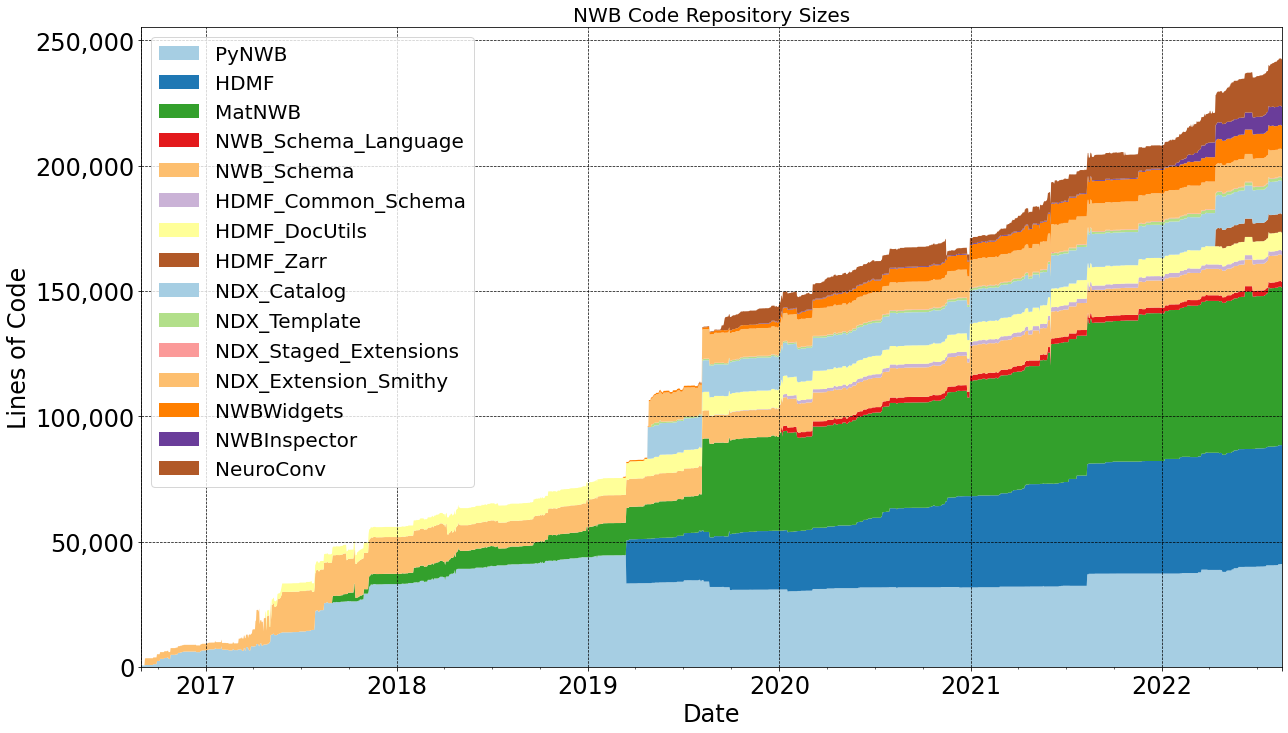

In [7]:
evenly_spaced_interval = np.linspace(0, 1, len(summary_plot_repos))
#colors = [cm.tab20(x) for x in evenly_spaced_interval]
colors = [cm.Paired(x) for x in evenly_spaced_interval]
# mix up colors so that neighbouring areas have more dissimilar colors
colors = [c for i, c in enumerate(colors) if i % 2 == 0] + [c for i, c in enumerate(colors) if i % 2 == 1]
ax = repo_sizes_algined_df[summary_plot_repos].plot.area(
    figsize=(18,10), 
    stacked=True, 
    linewidth=0,
    fontsize=24, 
    color=colors)
ax.get_yaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.legend(loc=2, prop={'size': 20})
plt.ylabel('Lines of Code', fontsize=24)
plt.xlabel('Date', fontsize=24)
plt.grid(color='black', linestyle='--', linewidth=0.7, axis='both')
plt.tight_layout()
if save_figs:
    plt.savefig(os.path.join(plot_dir, 'nwb_repo_sizes_all.pdf'))
plt.title('NWB Code Repository Sizes', fontsize=20)
plt.show()

### 3.2.1 Plot grouped summary of the lines of code across all NWB repos 

For the paper we want to group tools to ease overview.

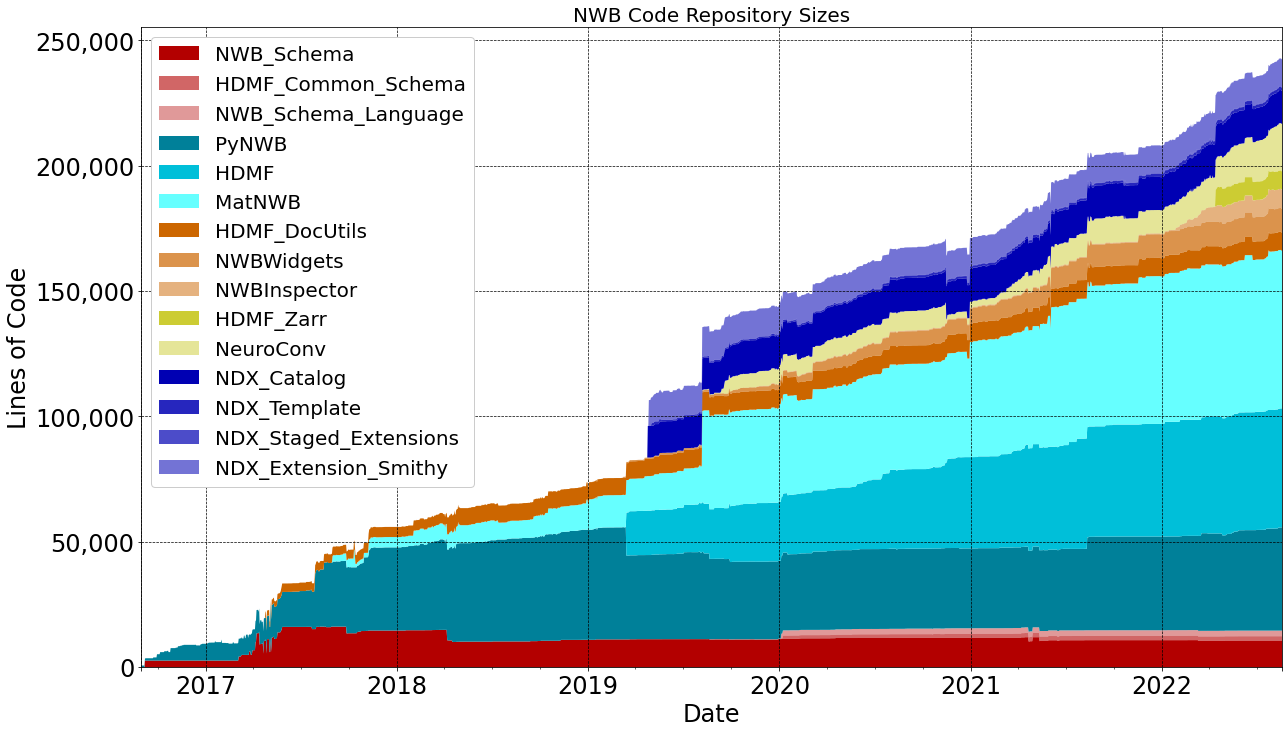

In [14]:
# Sort repos so we can group them category
summary_plot_repos_accum = [
     'NWB_Schema', 'HDMF_Common_Schema', 'NWB_Schema_Language', 
     'PyNWB', 
     'HDMF',
     'MatNWB',
     'HDMF_DocUtils', 'NWBWidgets', 'NWBInspector',
     'HDMF_Zarr', 'NeuroConv',
     'NDX_Catalog', 'NDX_Template', 'NDX_Staged_Extensions', 'NDX_Extension_Smithy']
colors = [(0.7, 0.0, 0.0, 1.0), (0.7, 0.0, 0.0, 0.6), (0.7, 0.0, 0.0, 0.4),
          (0.0, 0.5, 0.6, 1.0),
          (0.0, 0.75, 0.85, 1.0),
          (0.4, 1.0, 1.0 ,1.0),
          (0.8, 0.4, 0.0, 1.0), (0.8, 0.4, 0.0, 0.7), (0.8, 0.4, 0.0, 0.5),
          (0.8, 0.8, 0.2, 1.0), (0.8, 0.8, 0.2, 0.5),
          (0.0, 0.0, 0.7, 1.0), (0.0, 0.0, 0.7, 0.85), (0.0, 0.0, 0.7, 0.7), (0.0, 0.0, 0.7, 0.55)]
ax = repo_sizes_algined_df[summary_plot_repos_accum].plot.area(
    figsize=(18,10), 
    stacked=True, 
    linewidth=0,
    fontsize=24, 
    color=colors)
ax.get_yaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.get_legend().remove()
plt.ylabel('Lines of Code', fontsize=24)
plt.xlabel('Date', fontsize=24)
plt.grid(color='black', linestyle='--', linewidth=0.7, axis='both')
plt.tight_layout()
plt.legend(loc=2, prop={'size': 20,}, facecolor=(1.0, 1.0, 1.0, 1.0), framealpha=1.0)
if save_figs:
    plt.savefig(os.path.join(plot_dir, 'nwb_repo_sizes_all_grouped.pdf'))
plt.title('NWB Code Repository Sizes', fontsize=20)
plt.show()

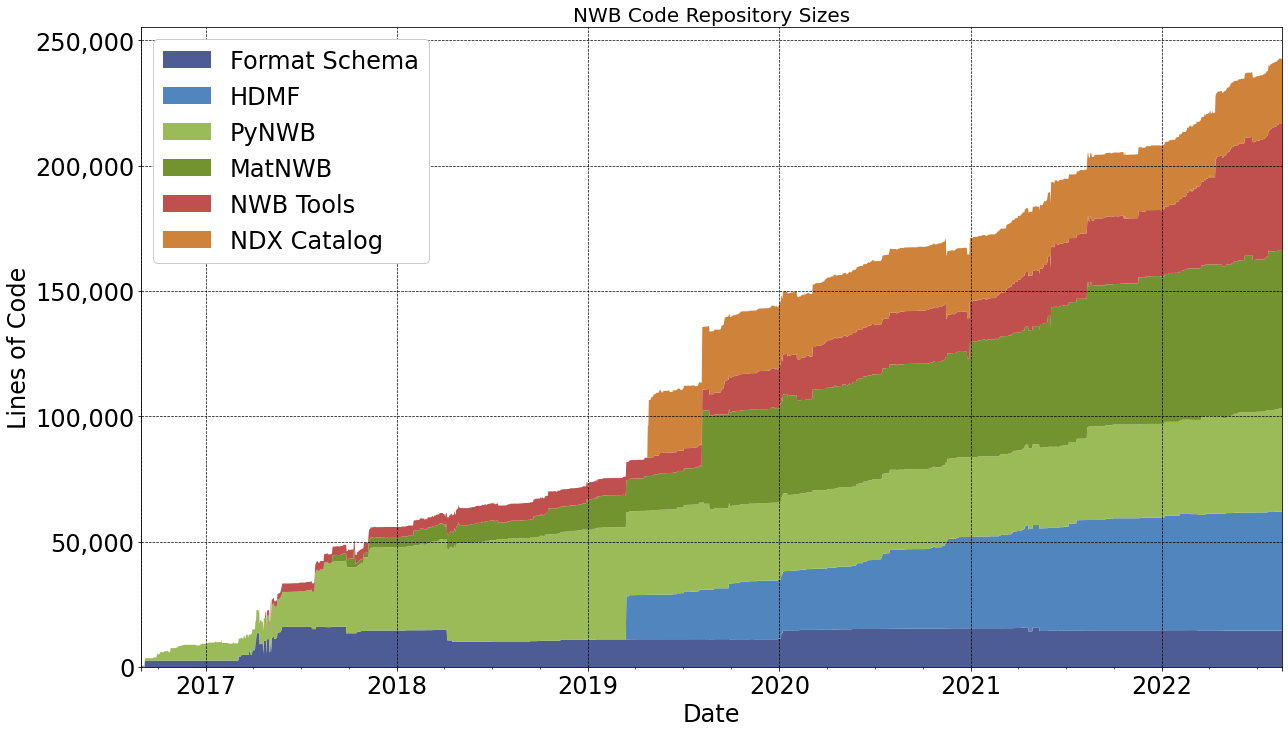

In [9]:
repo_sizes_grouped_df = pd.DataFrame.from_dict(
    {'Format Schema': (repo_sizes_algined_df['NWB_Schema'] + 
                       repo_sizes_algined_df['HDMF_Common_Schema'] + 
                       repo_sizes_algined_df['NWB_Schema_Language']),
     'HDMF': repo_sizes_algined_df['HDMF'],
     'PyNWB': repo_sizes_algined_df['PyNWB'],
     'MatNWB': repo_sizes_algined_df['MatNWB'],
     'NWB Tools': (repo_sizes_algined_df['HDMF_DocUtils'] + 
                   repo_sizes_algined_df['NWBWidgets'] + 
                   repo_sizes_algined_df['NWBInspector'] + 
                   repo_sizes_algined_df['HDMF_Zarr'] + 
                   repo_sizes_algined_df['NeuroConv']),
     'NDX Catalog': (repo_sizes_algined_df['NDX_Catalog'] +
                     repo_sizes_algined_df['NDX_Template'] +
                     repo_sizes_algined_df['NDX_Staged_Extensions'] +
                     repo_sizes_algined_df['NDX_Extension_Smithy']),
    }
)
colors = [(78, 92, 150), (81, 133, 189), (155, 187, 89), (115, 147, 49), (191, 80, 77), (207, 130, 58)]
colors = [ (c[0]/255.0, c[1]/255.0, c[2]/255.0, 1.0) for c in colors]
ax = repo_sizes_grouped_df.plot.area(
    figsize=(18,10), 
    stacked=True, 
    linewidth=0,
    fontsize=24,
    color=colors)
ax.get_yaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.get_legend().remove()
plt.ylabel('Lines of Code', fontsize=24)
plt.xlabel('Date', fontsize=24)
plt.grid(color='black', linestyle='--', linewidth=0.7, axis='both')
plt.tight_layout()
plt.legend(loc=2, prop={'size': 24,}, facecolor=(1.0, 1.0, 1.0, 1.0), framealpha=1.0)
if save_figs:
    plt.savefig(os.path.join(plot_dir, 'nwb_repo_sizes_grouped.pdf'))
    
plt.title('NWB Code Repository Sizes', fontsize=20)
plt.show()

### 3.3. Plot per-repo total lines of code statistics broken down by: code, blank, comment

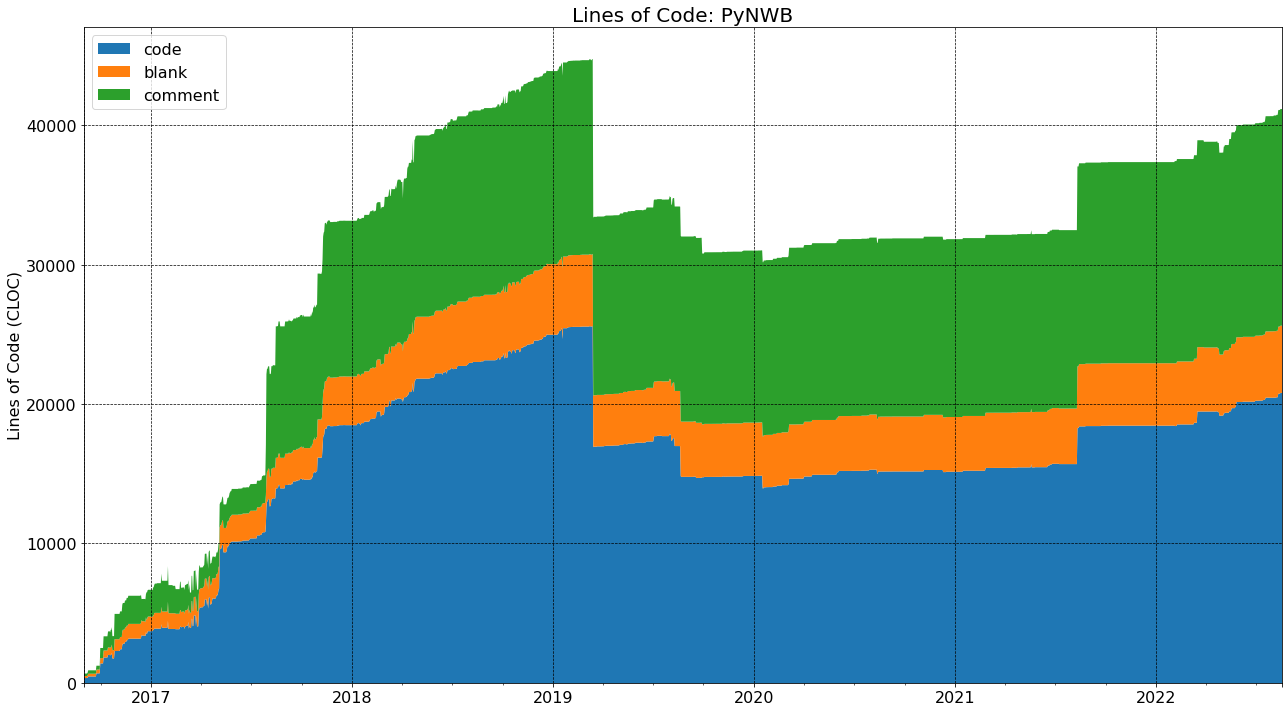

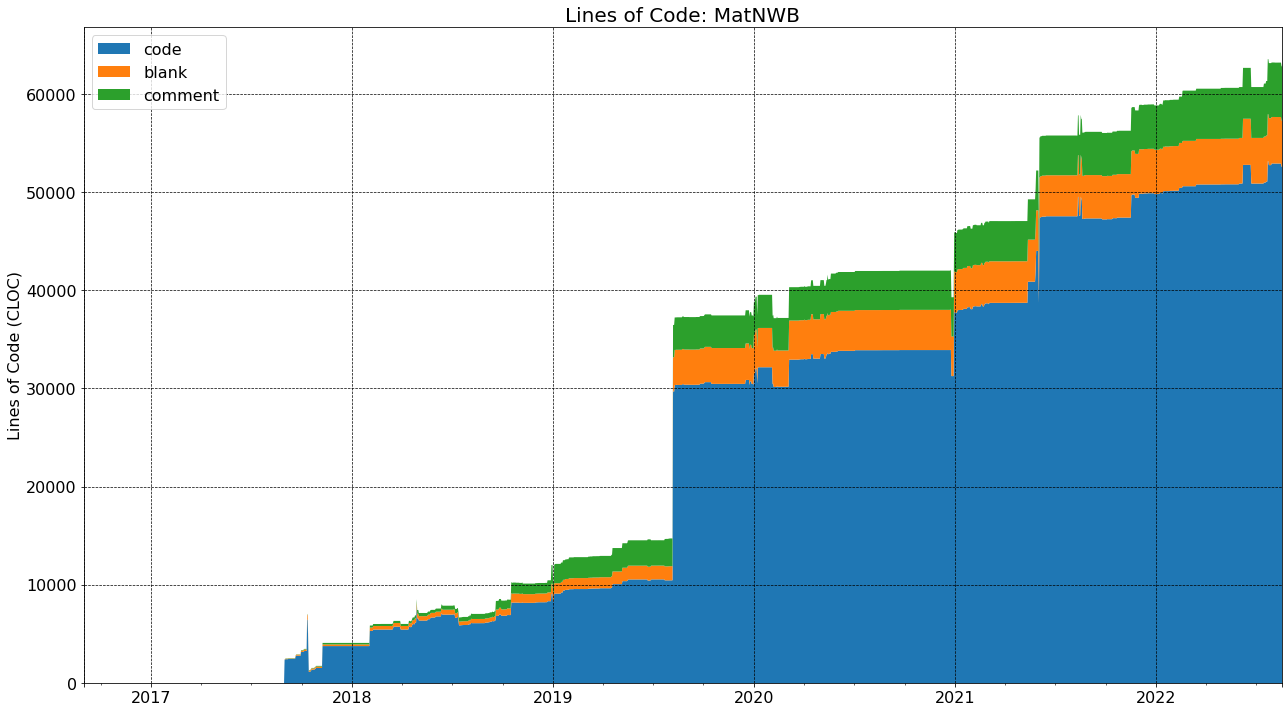

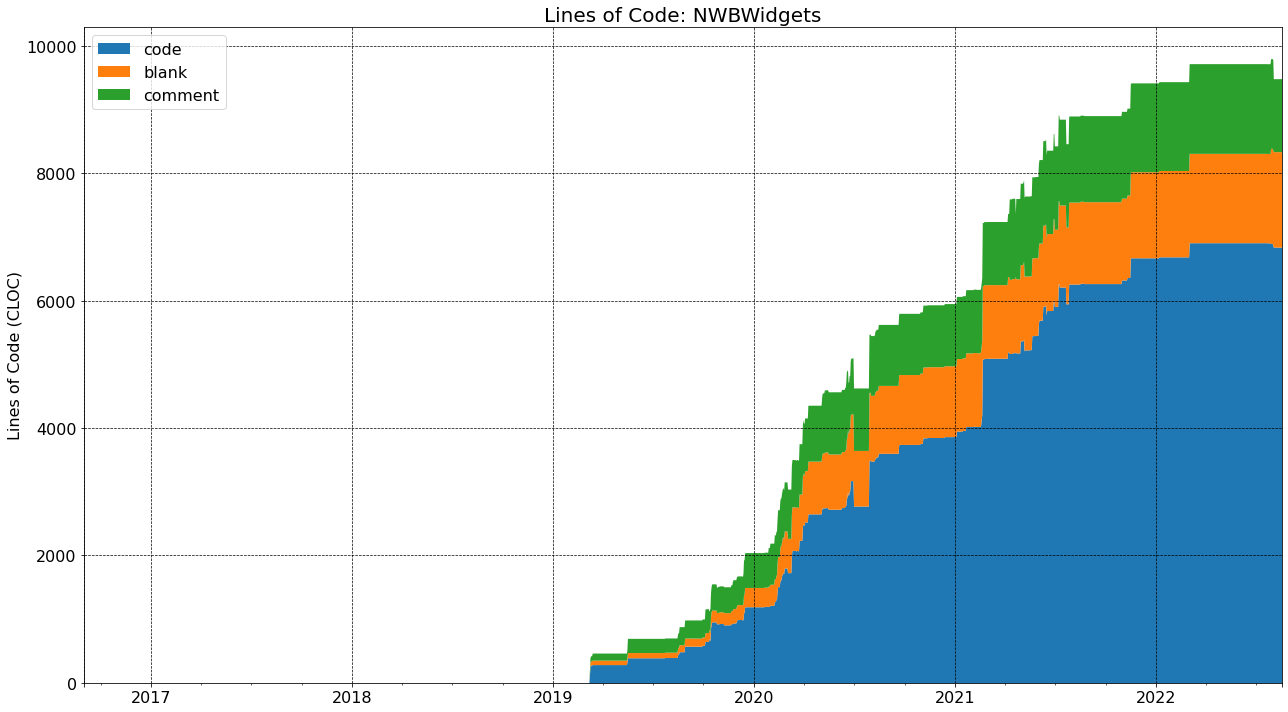

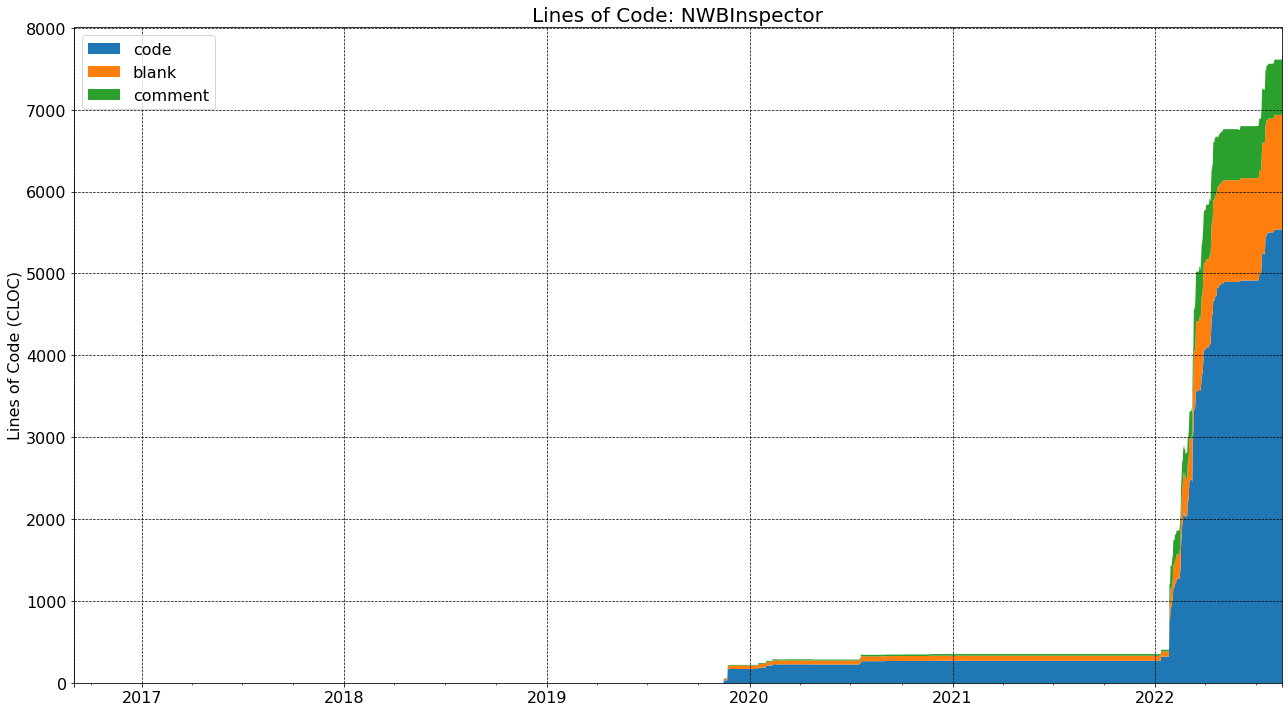

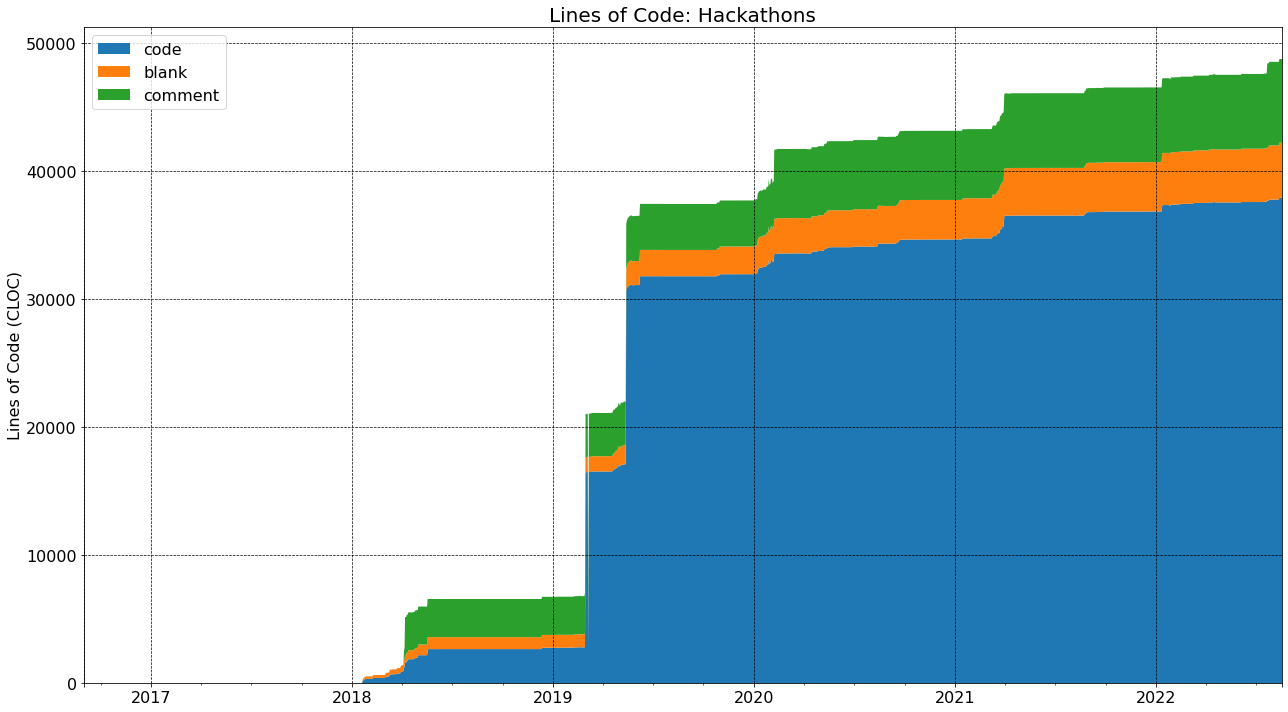

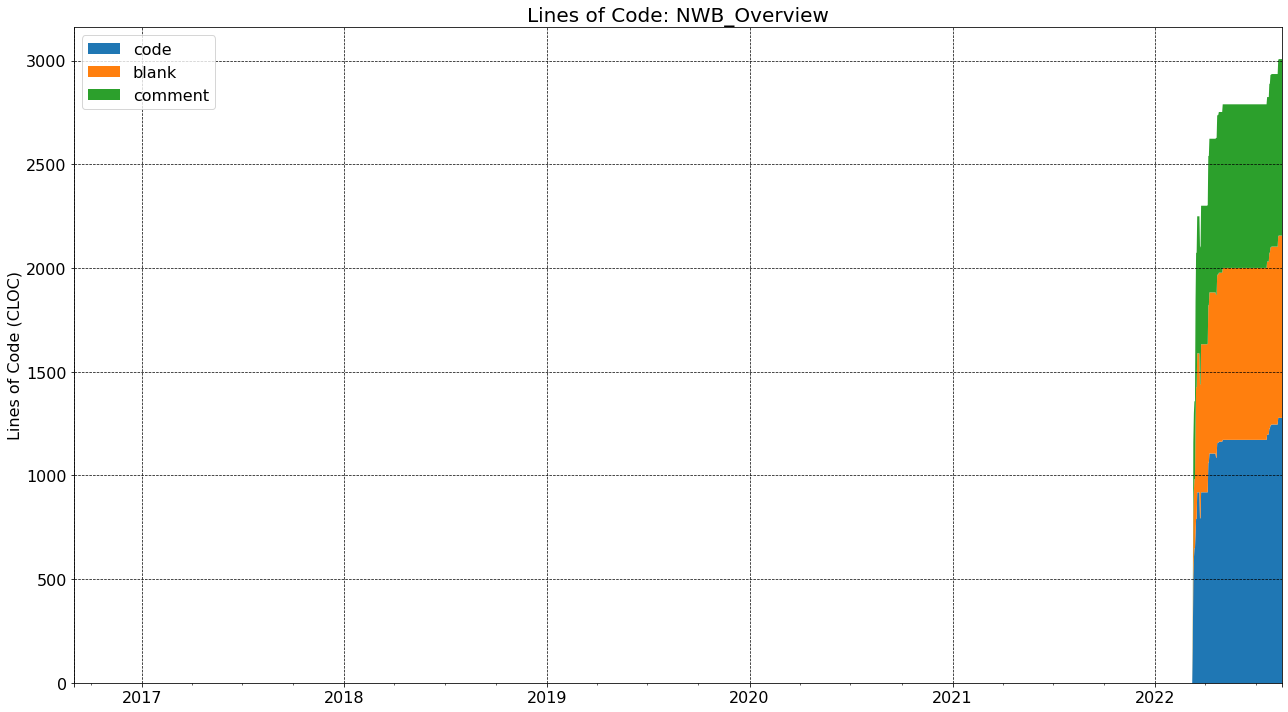

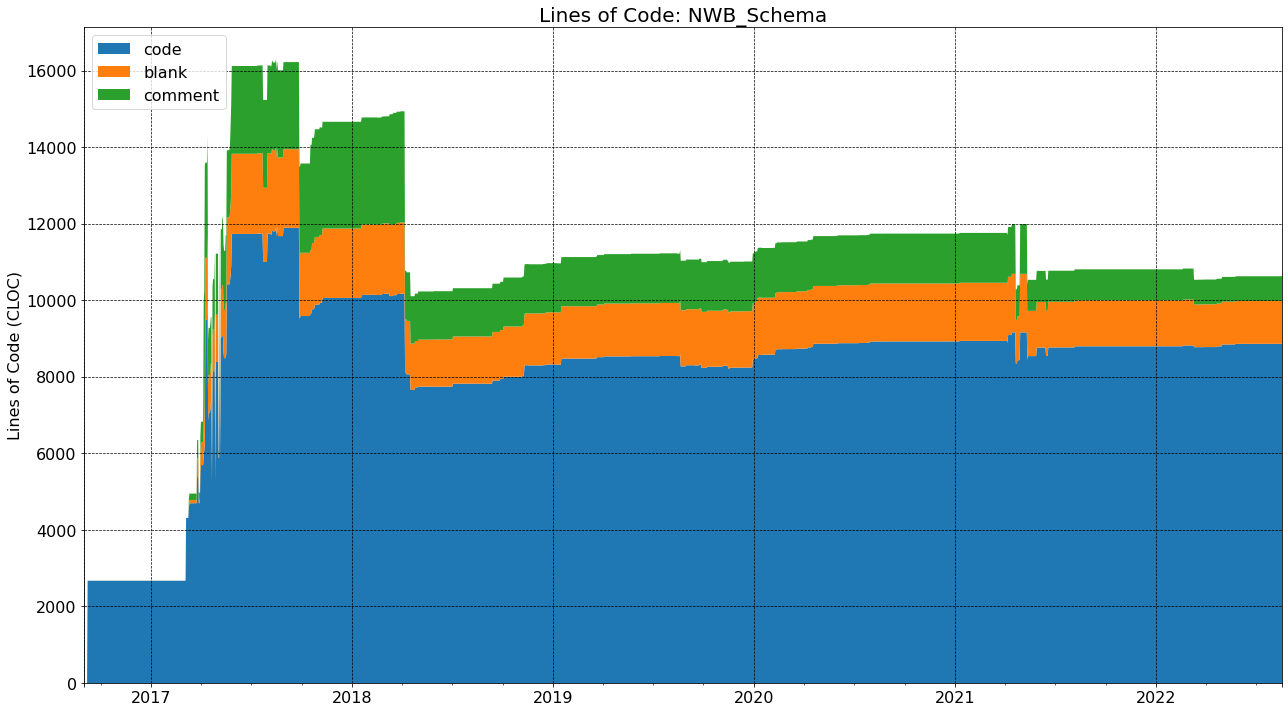

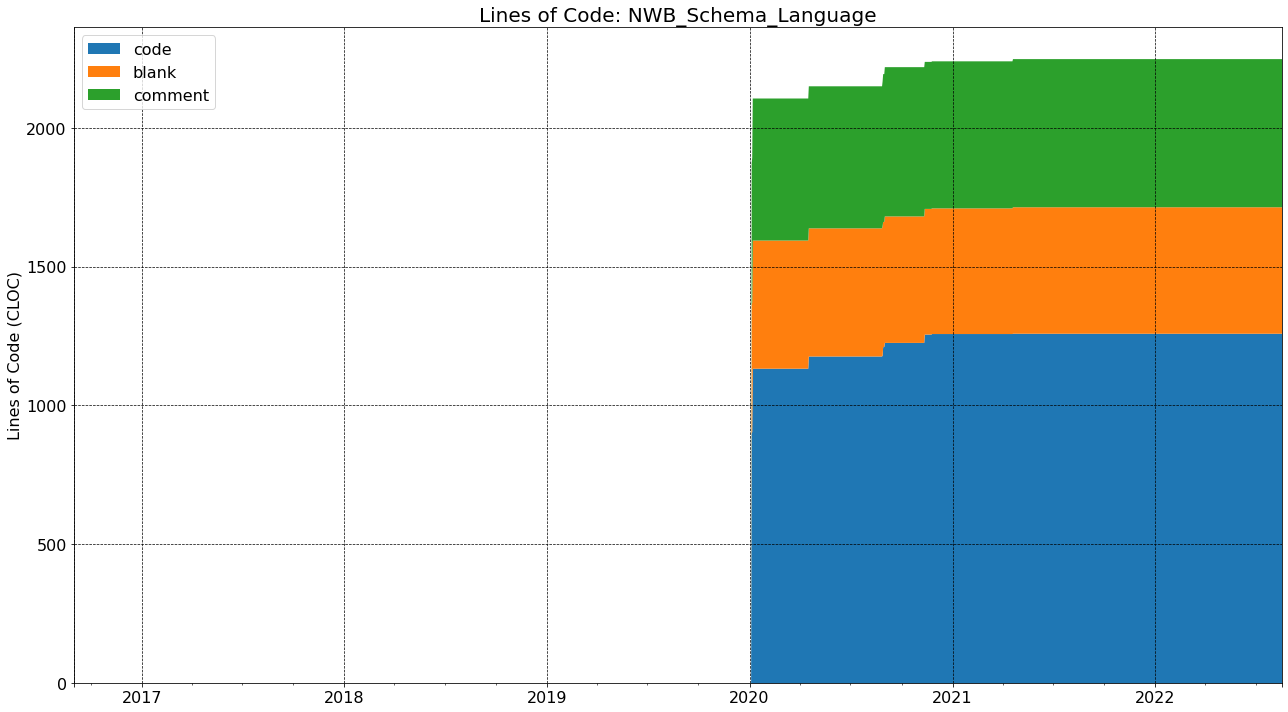

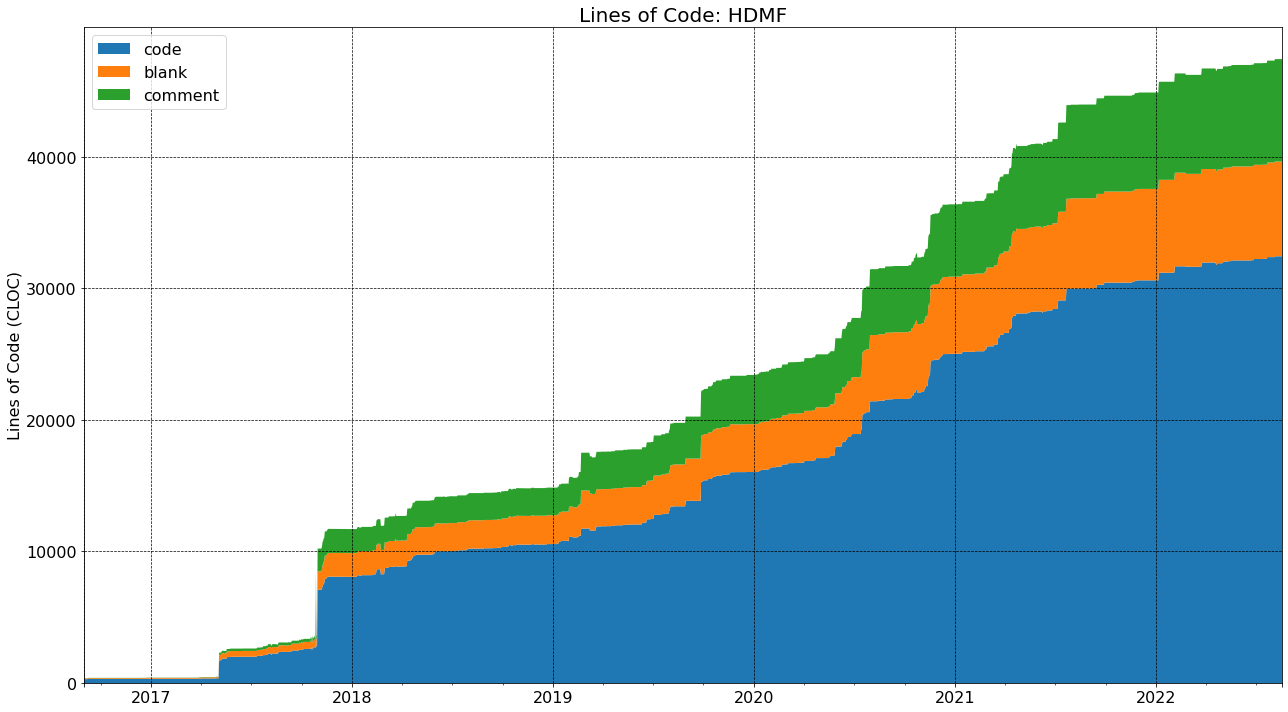

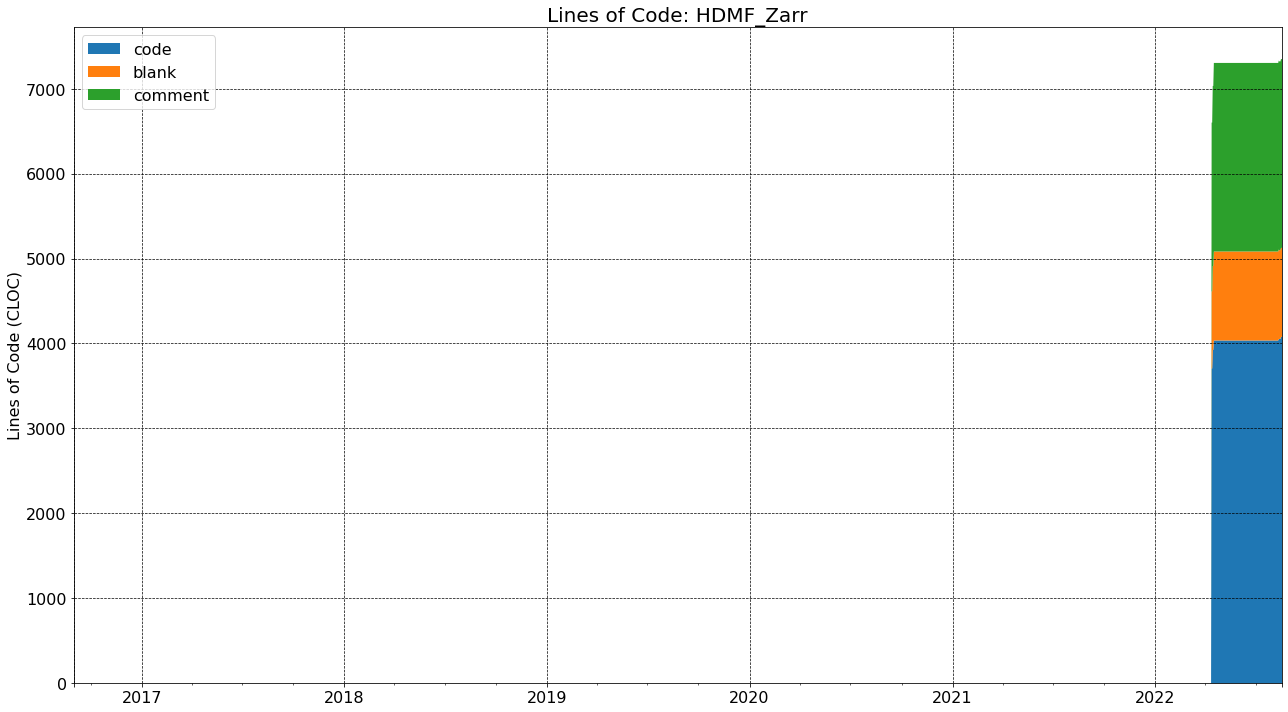

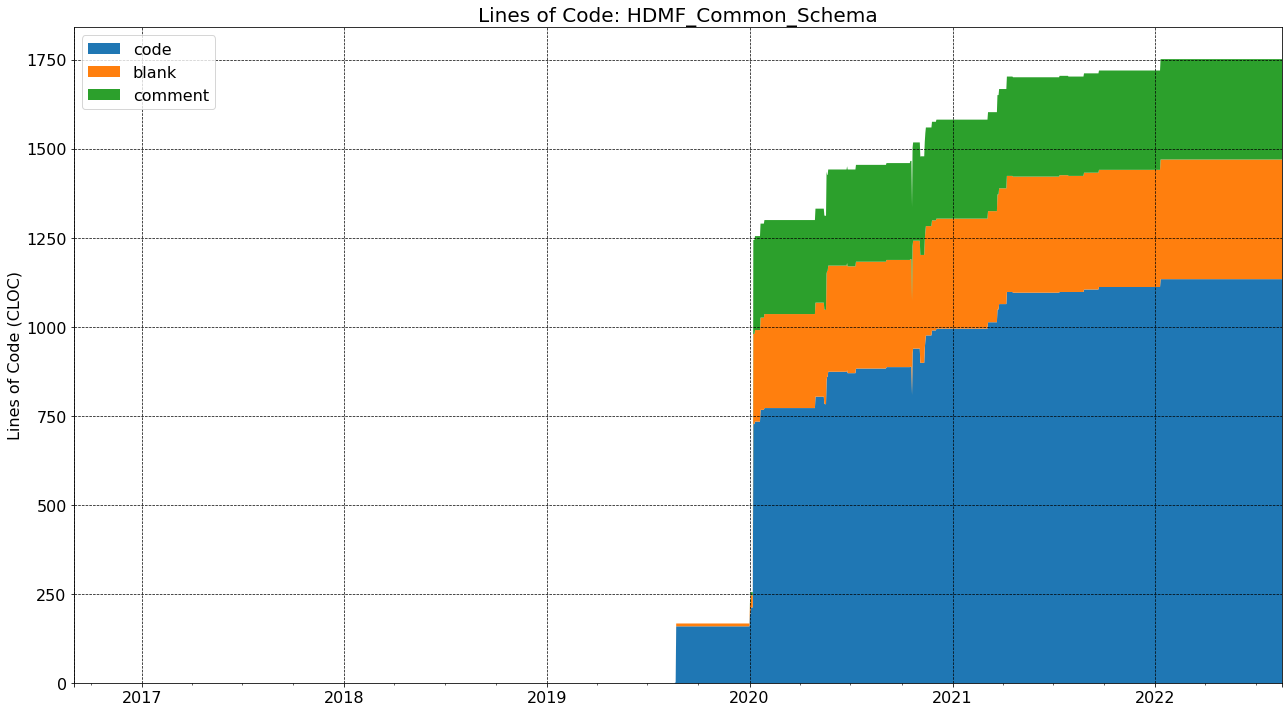

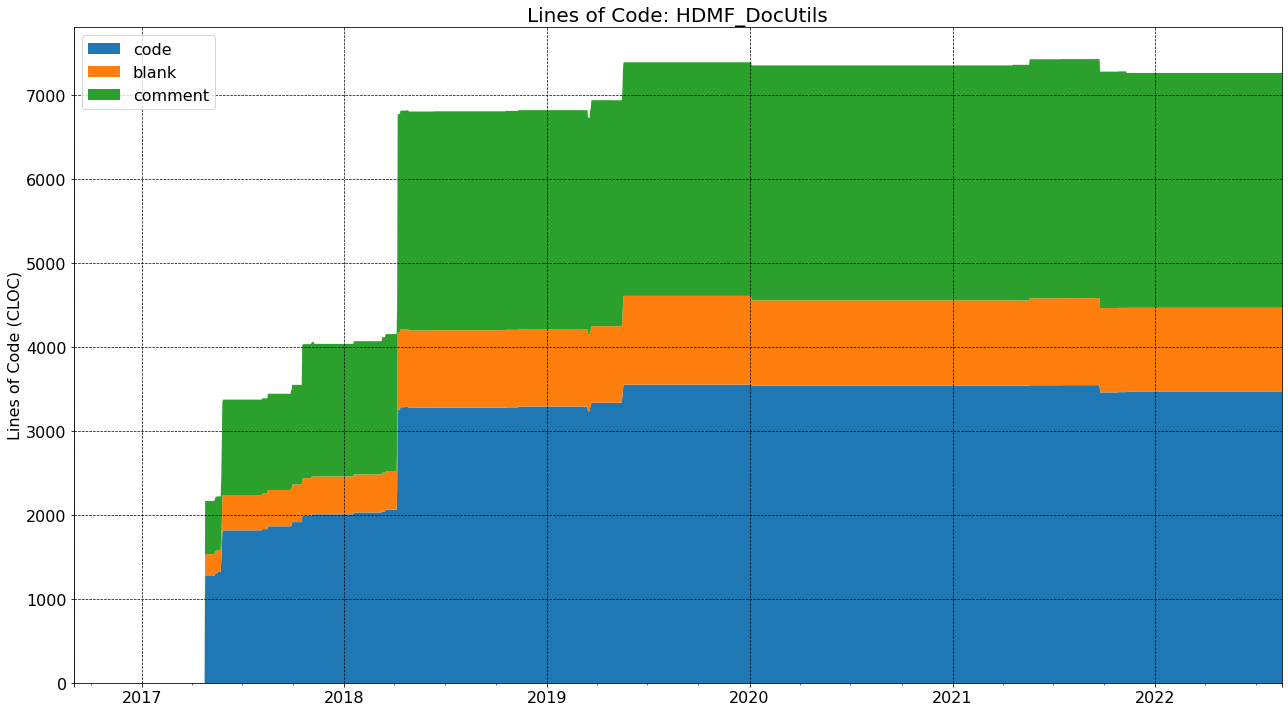

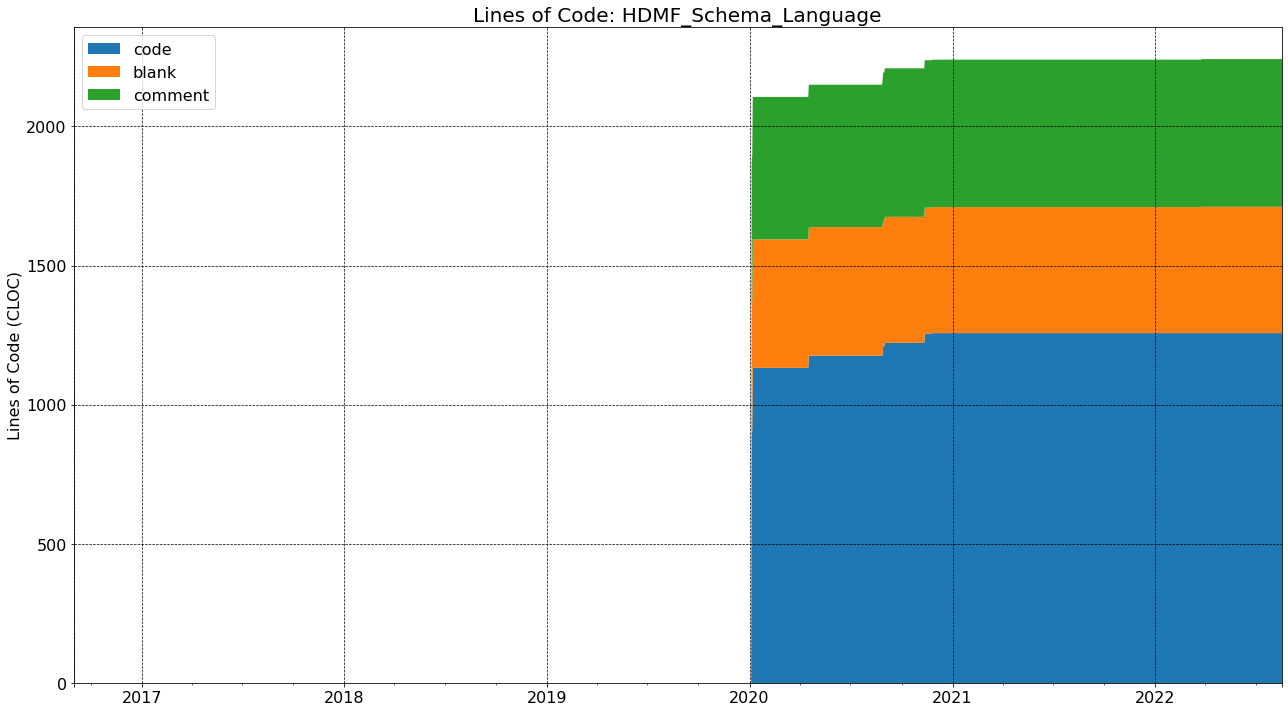

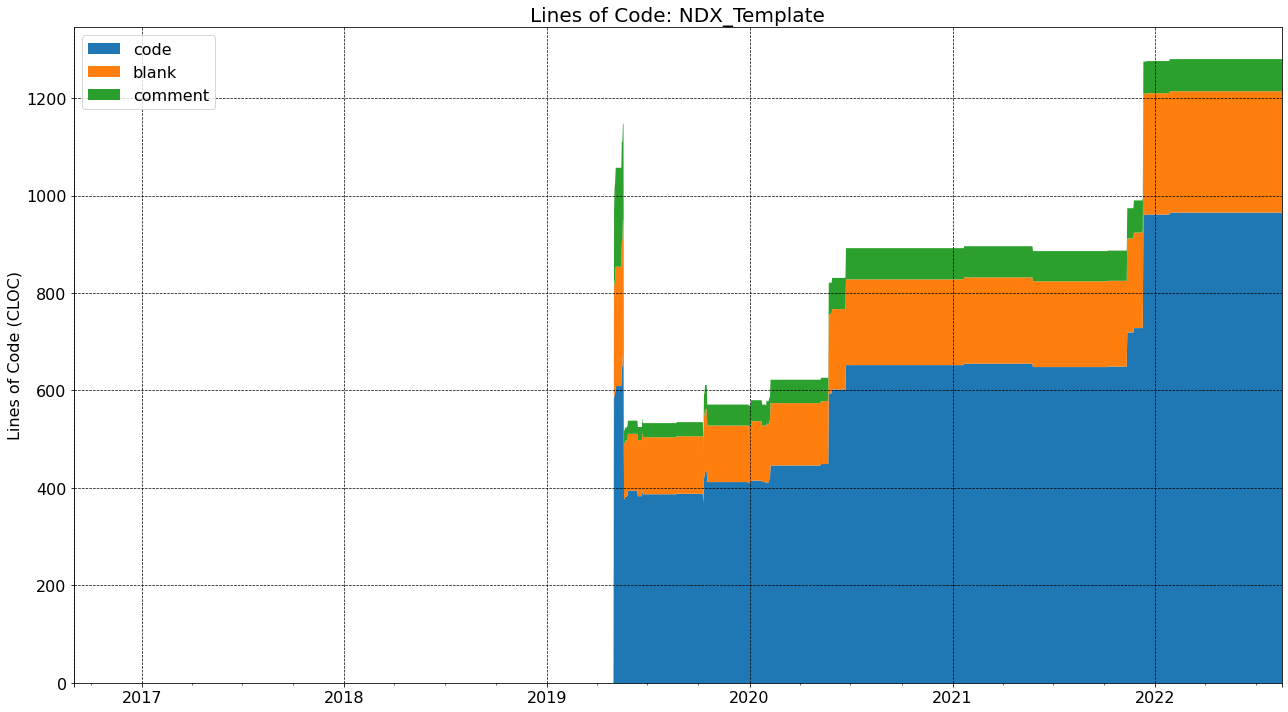

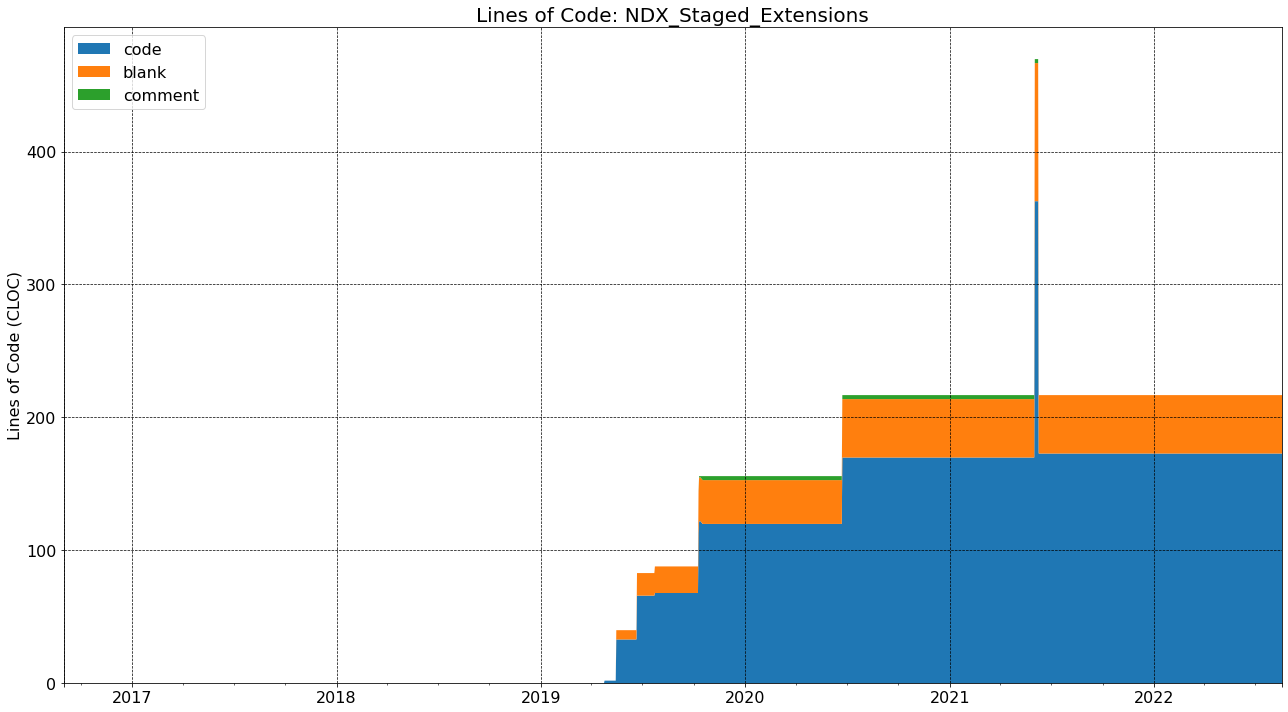

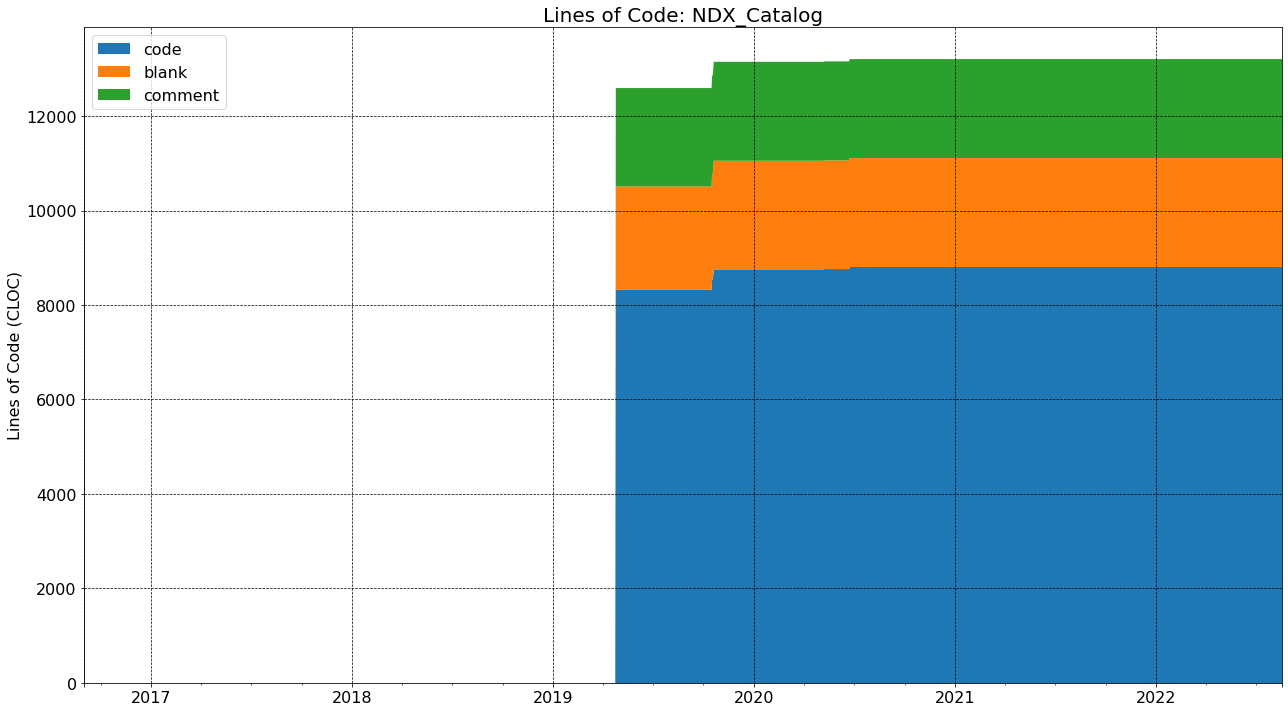

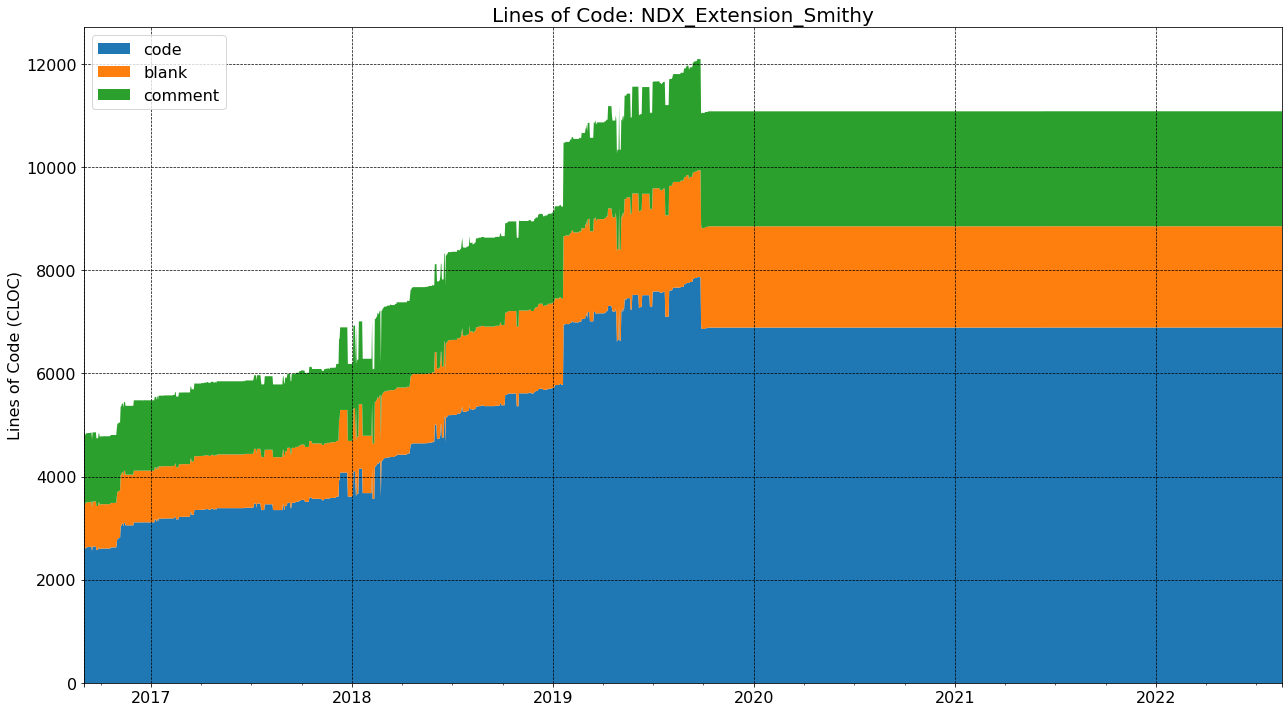

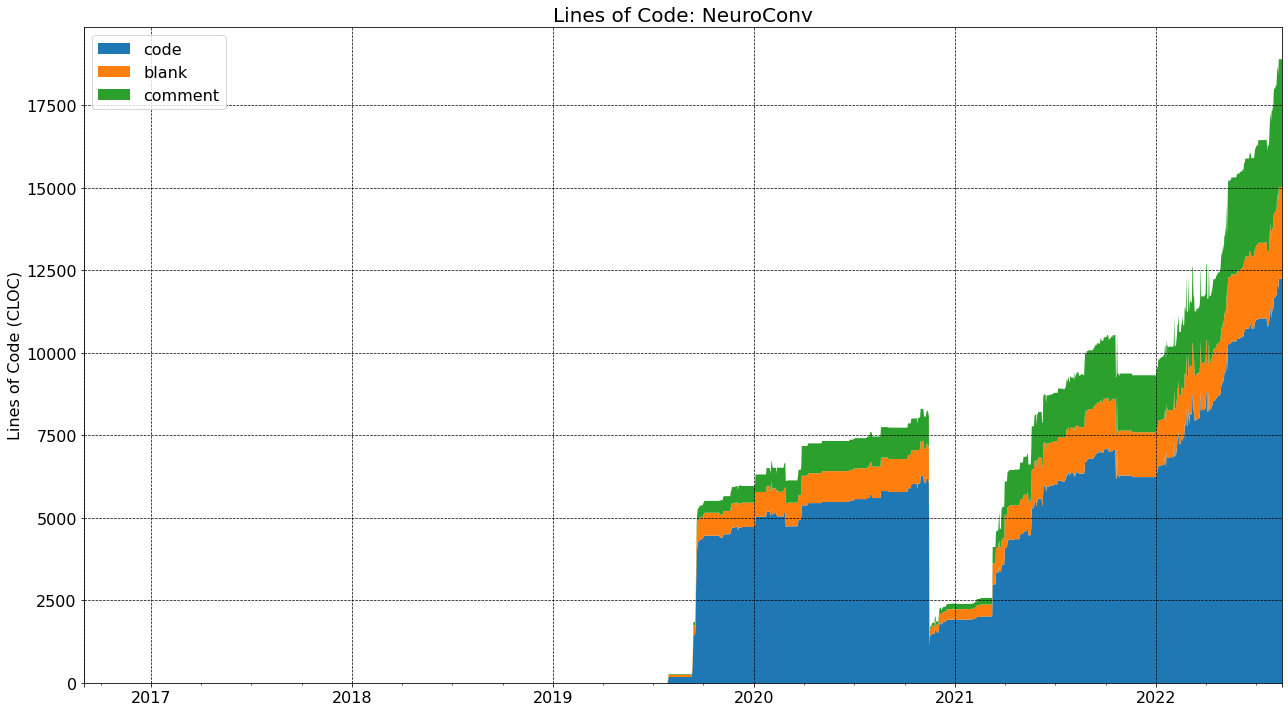

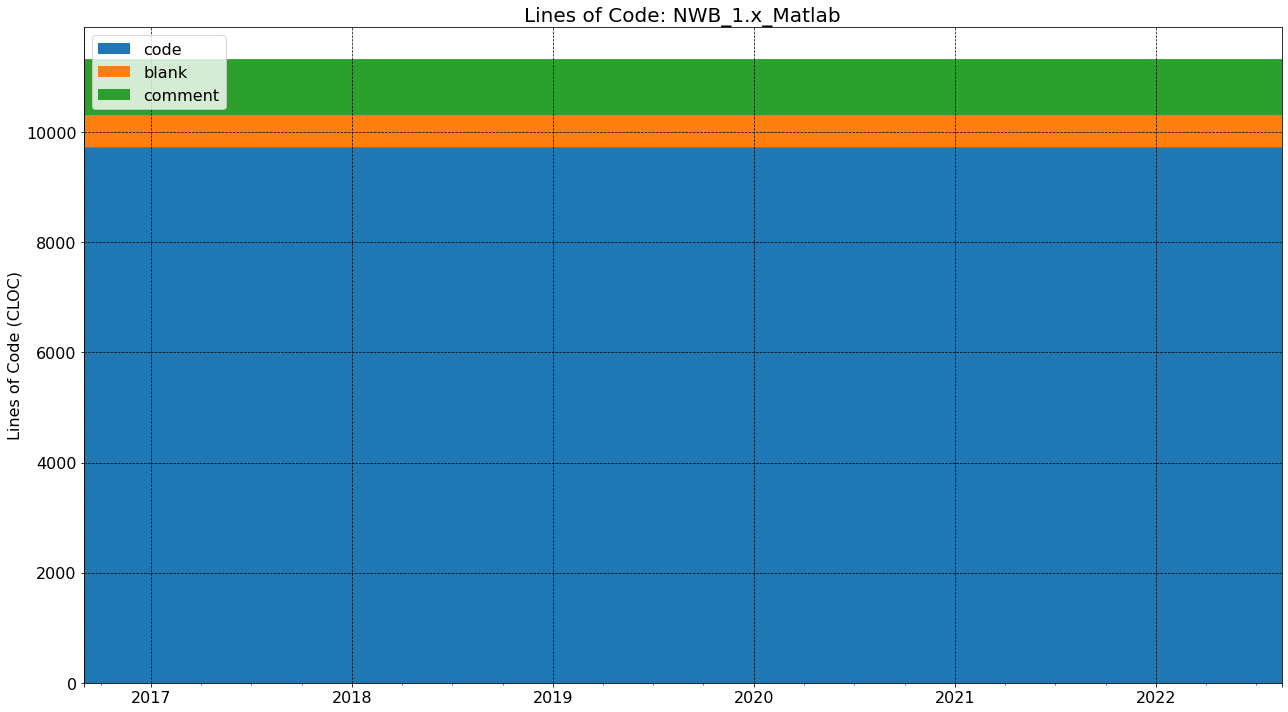

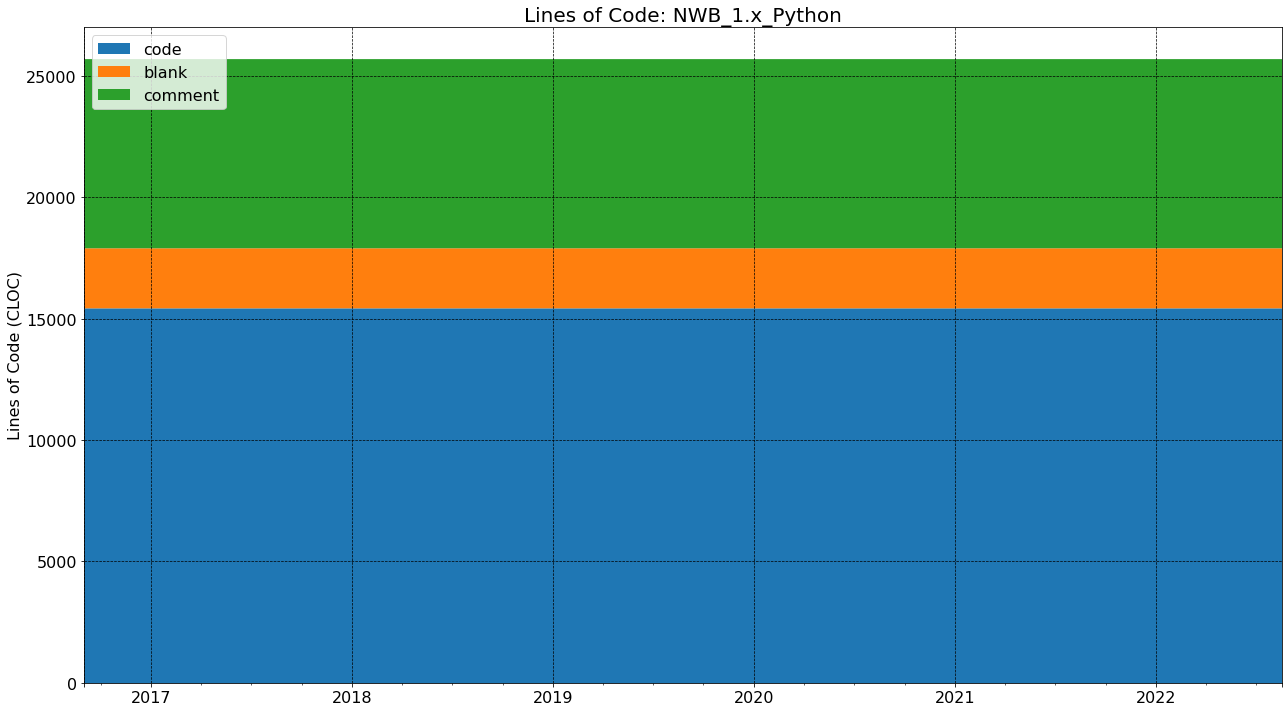

In [10]:
for k in git_paths.keys():
    curr_df = pd.DataFrame.from_dict({'code': repo_codes_aligned_df[k], 
                                      'blank': repo_blanks_aligned_df[k], 
                                      'comment': repo_comments_aligned_df[k]})
    curr_df.index = date_range
    curr_df.plot.area(
        figsize=(18,10), 
        stacked=True, 
        linewidth=0, 
        fontsize=16)
    plt.legend(loc=2, prop={'size': 16})
    plt.ylabel('Lines of Code (CLOC)', fontsize=16)
    plt.grid(color='black', linestyle='--', linewidth=0.7, axis='both')
    plt.title("Lines of Code: %s" % k, fontsize=20)
    plt.tight_layout()
    if save_figs:
        plt.savefig(os.path.join(plot_dir, '%s_loc.pdf' % k))
    plt.show()

## 4. Per-repo total lines of code statistics broken down by language type
### 4.1. Compute the per-repo language statistics

In [11]:
# Iterate through all repos 
ignore_lang = ['SUM', 'header']
languages_used_all = git_code_stats.get_languages_used(ignore_lang)
per_repo_lang_stats = git_code_stats.compute_language_stats(ignore_lang)

### 4.2. Plot the per-repo total lines of code statistics broken down by language type

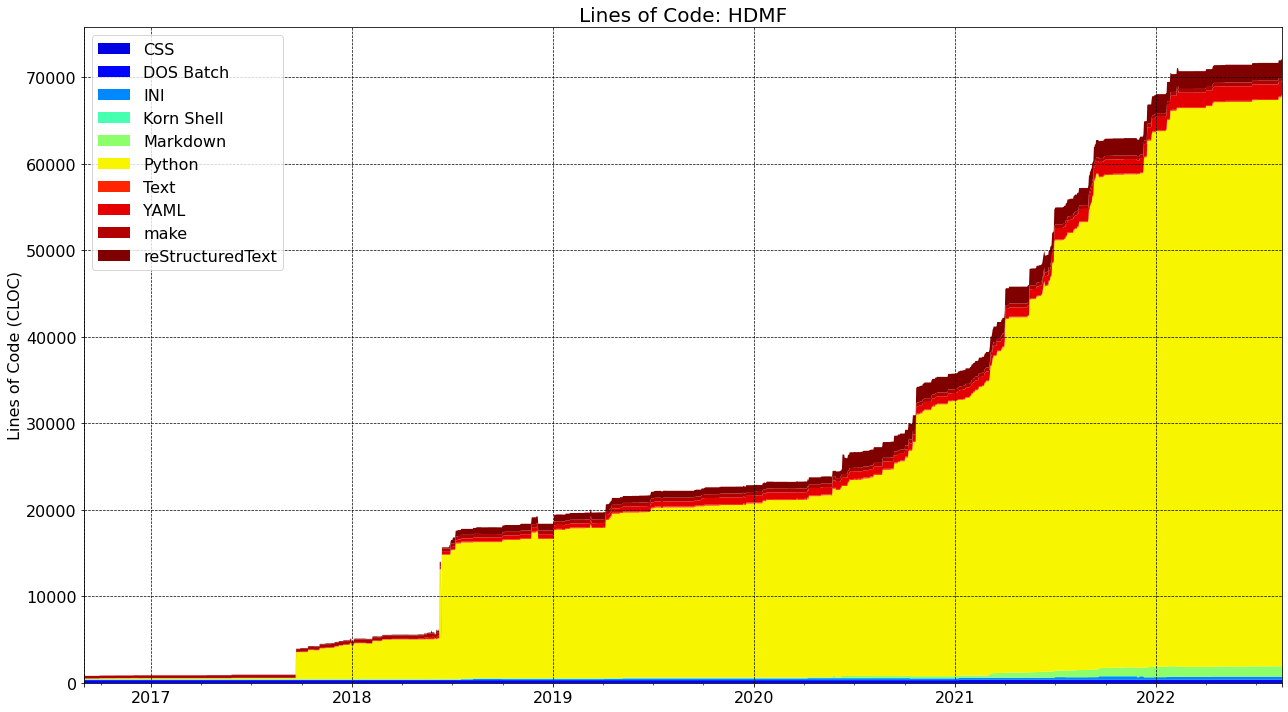

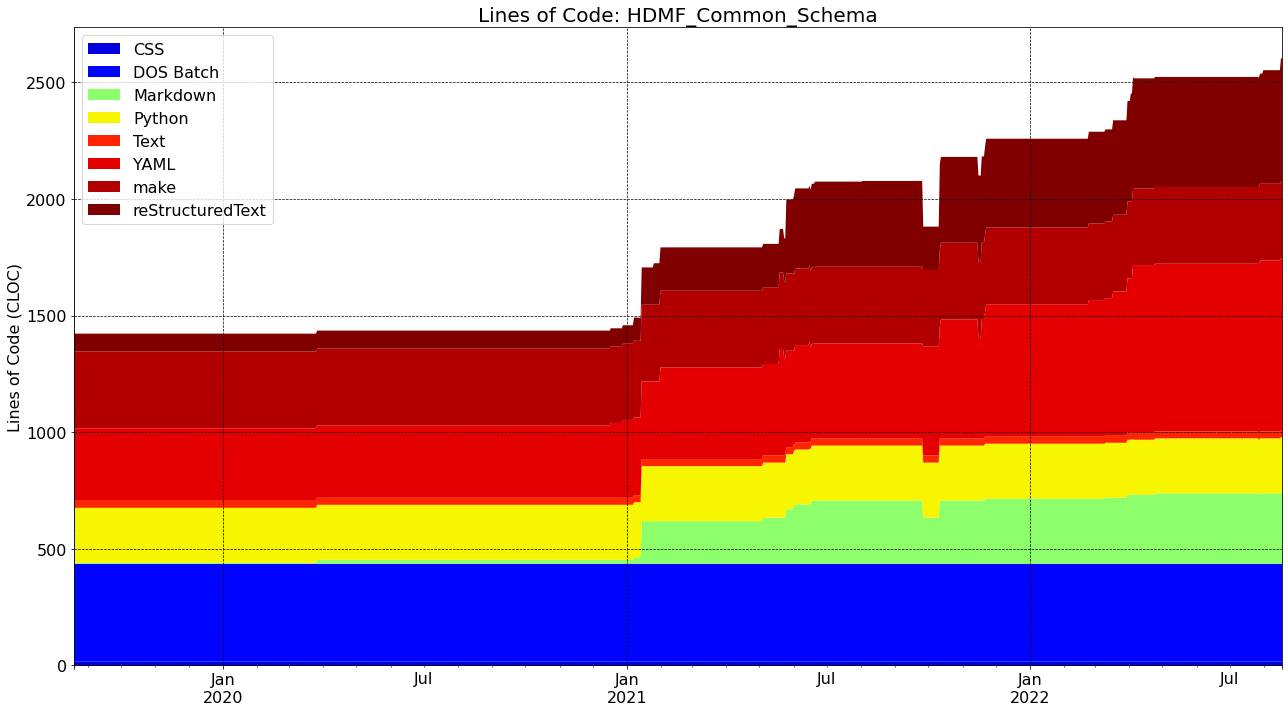

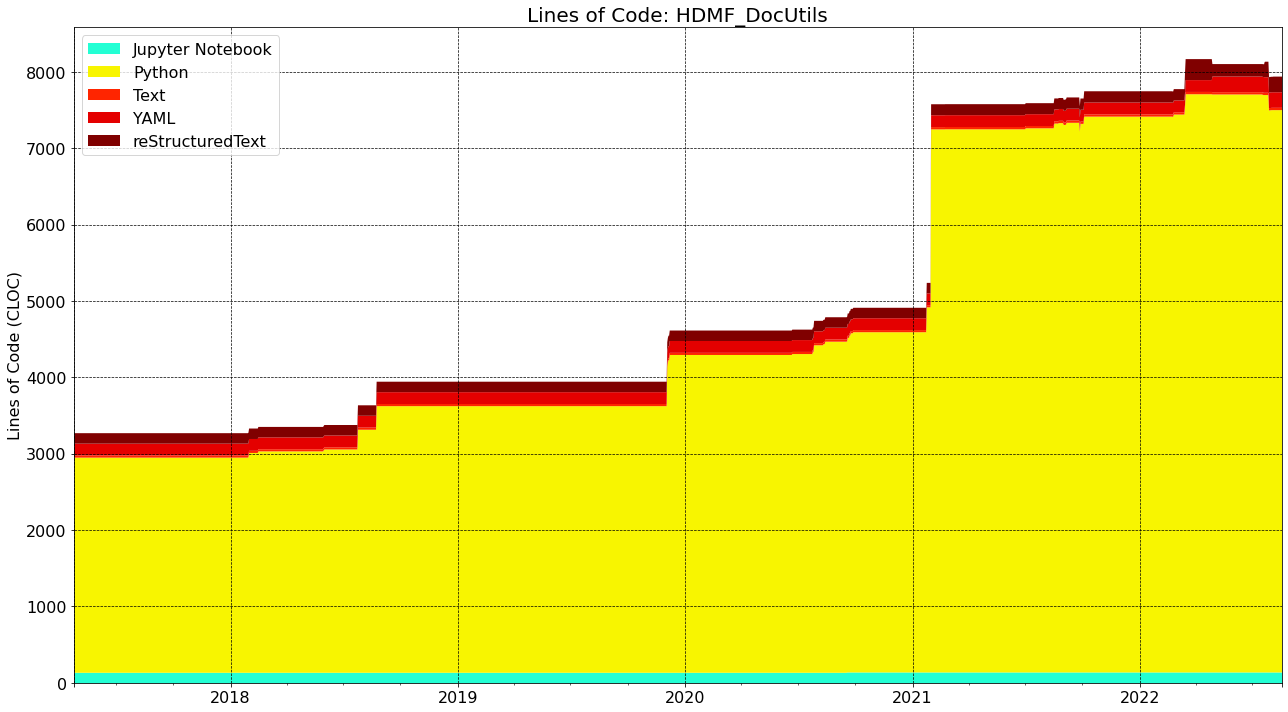

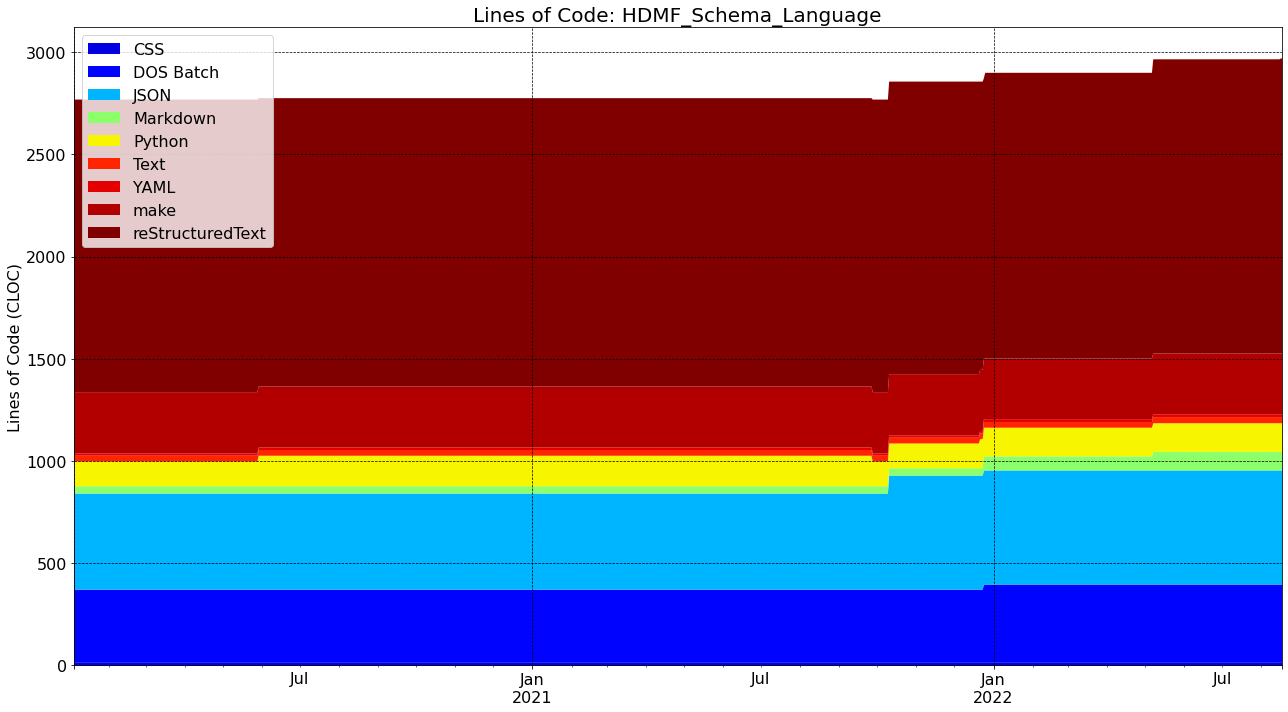

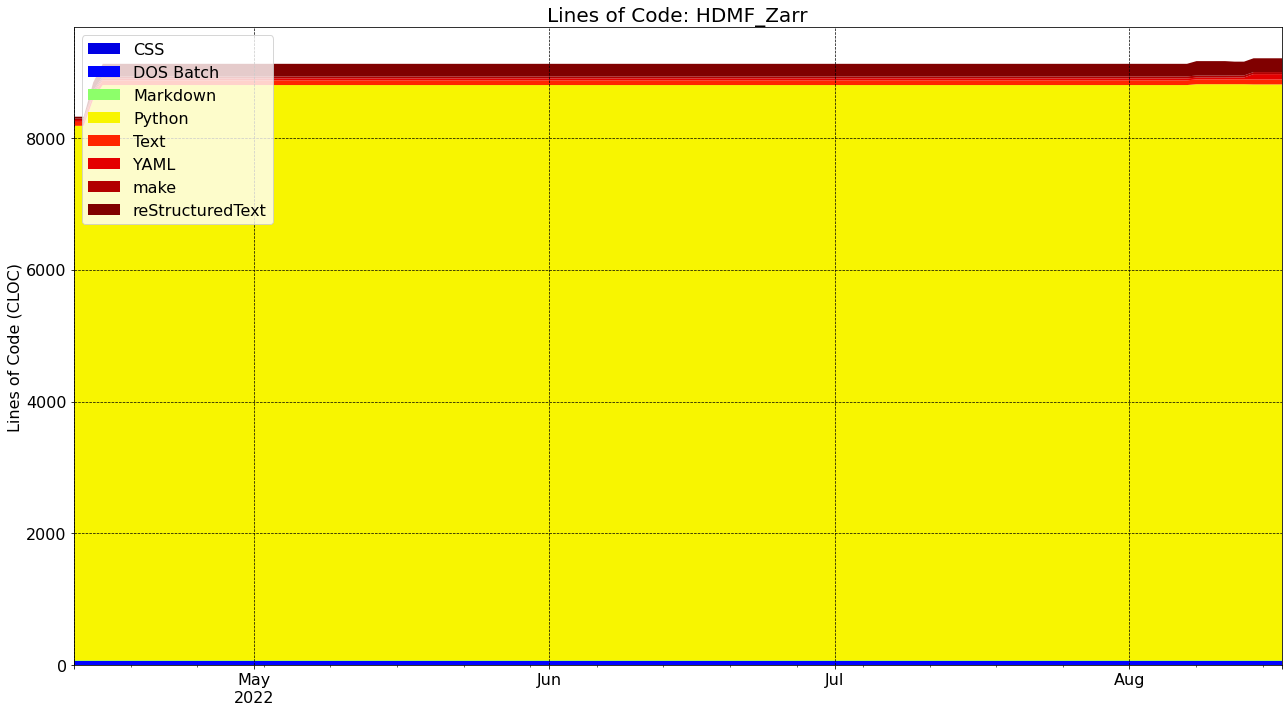

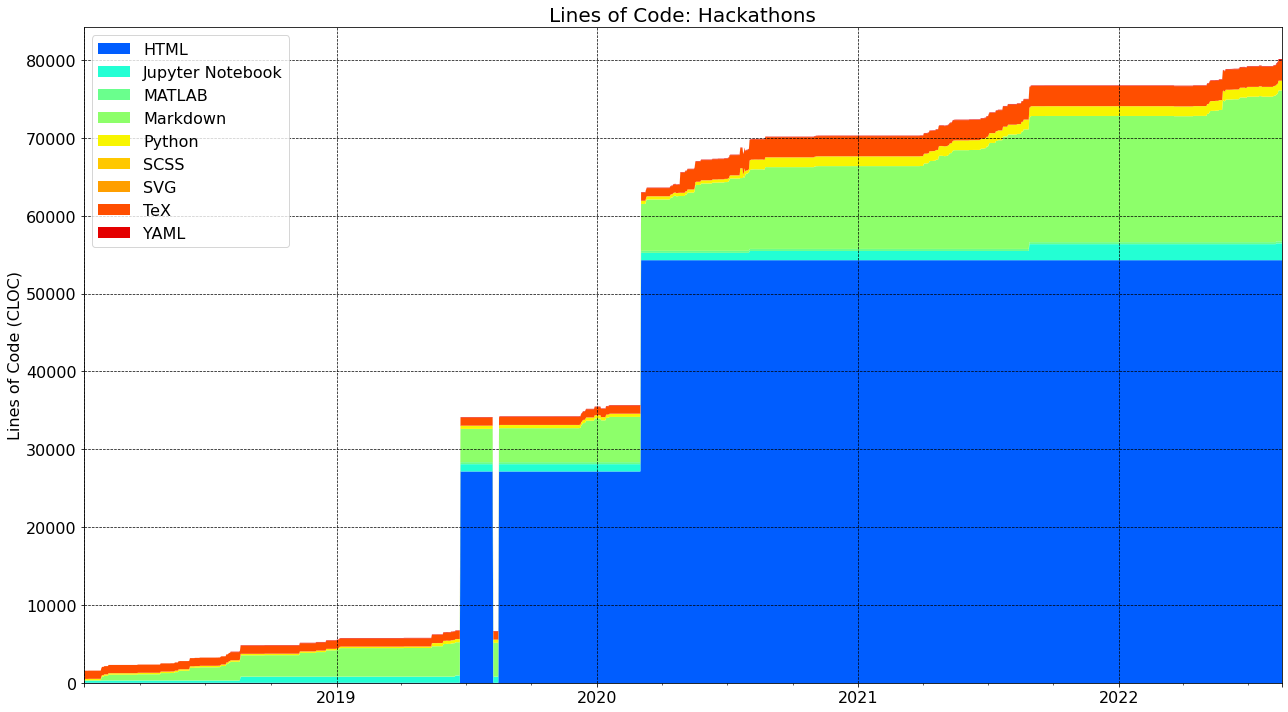

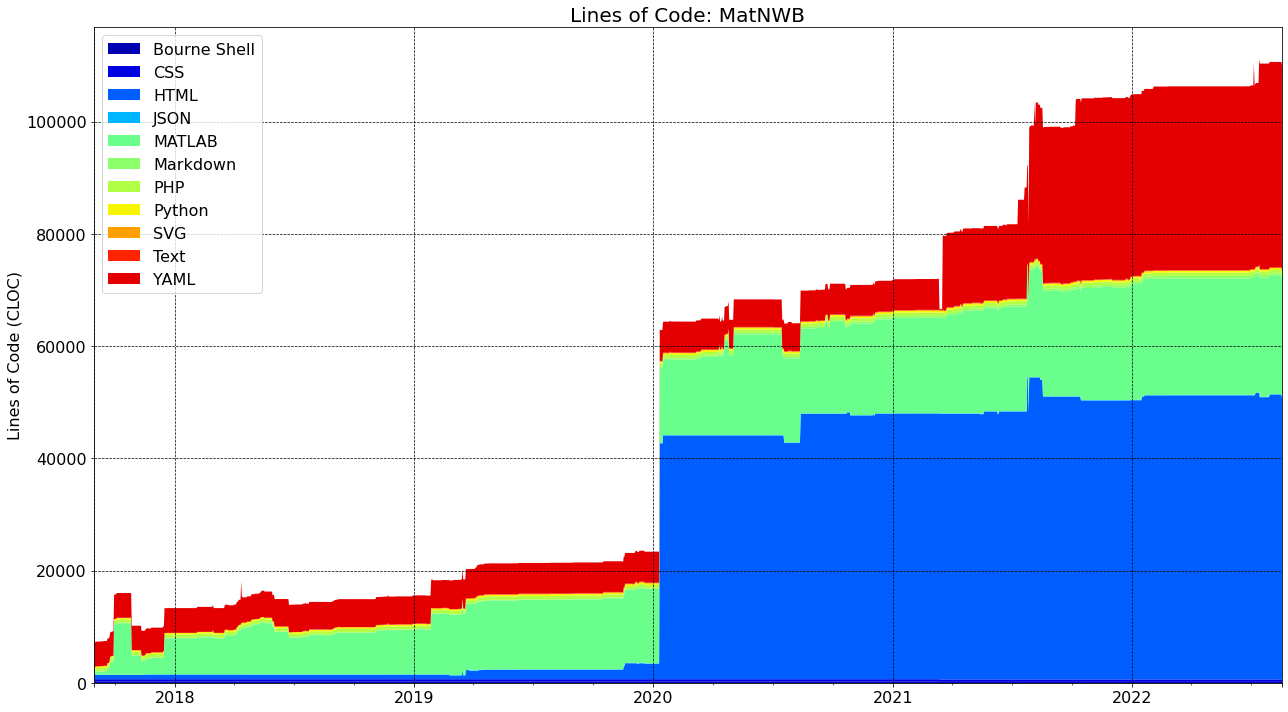

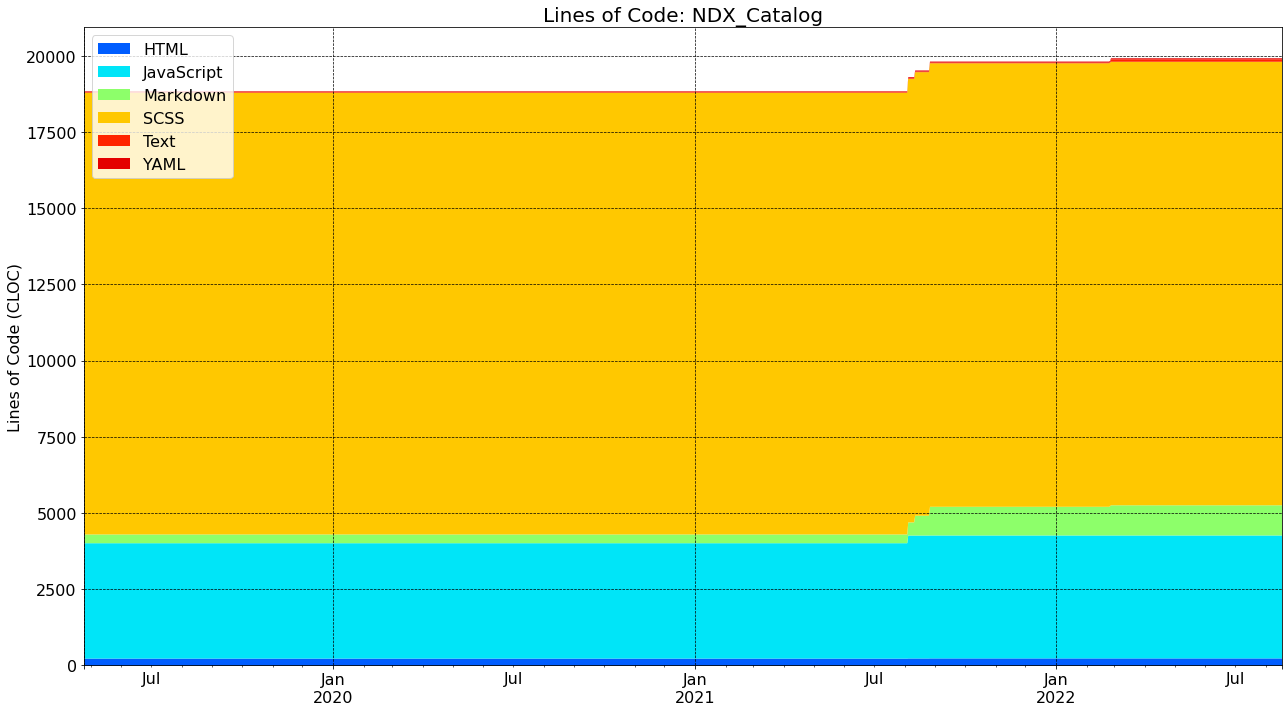

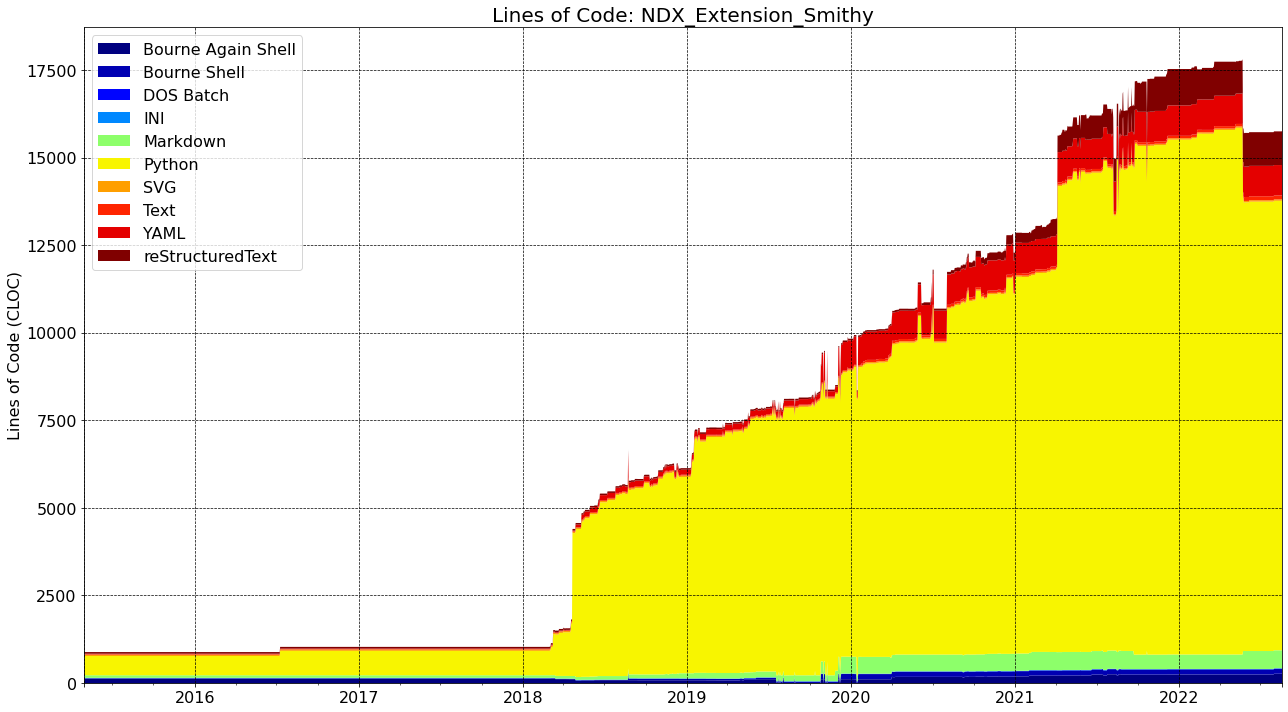

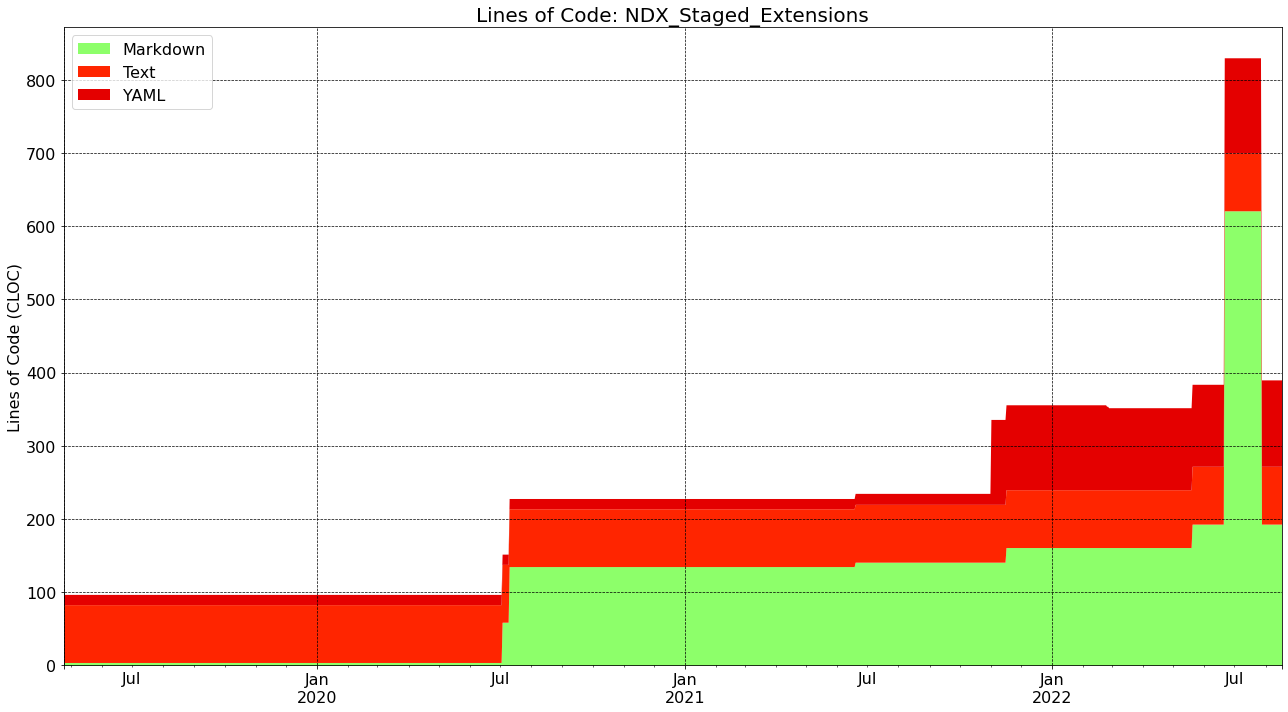

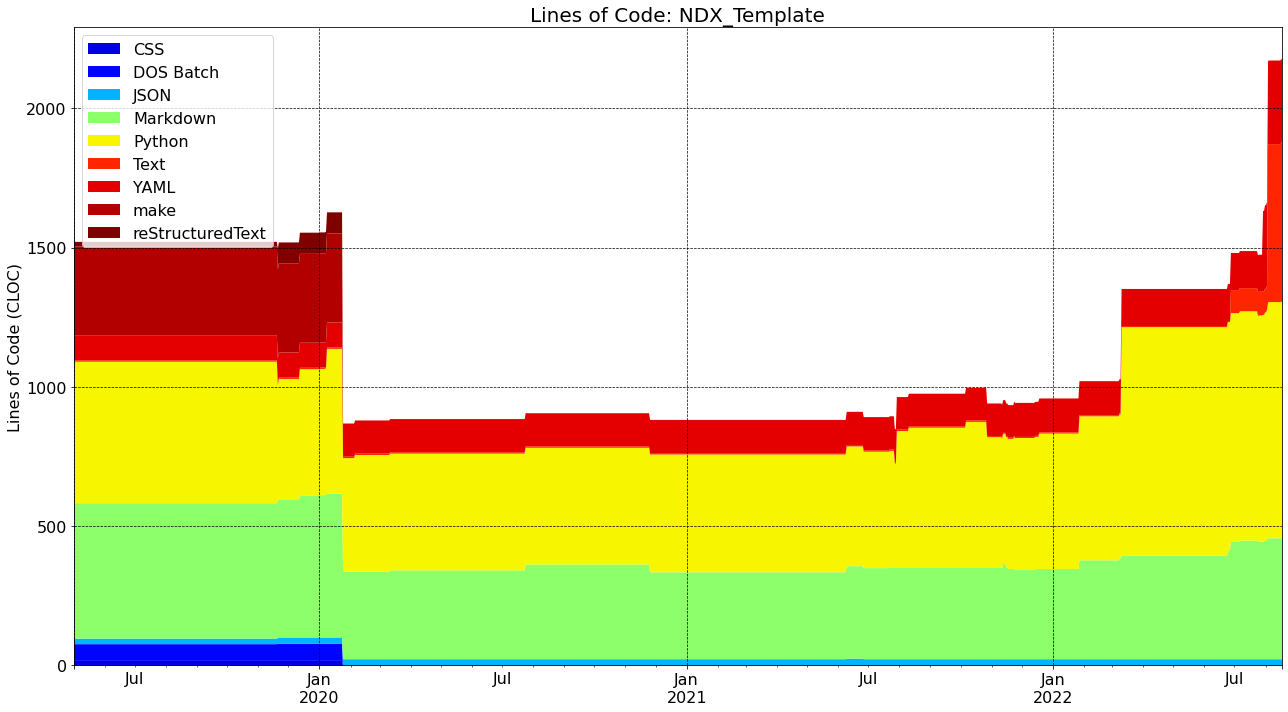

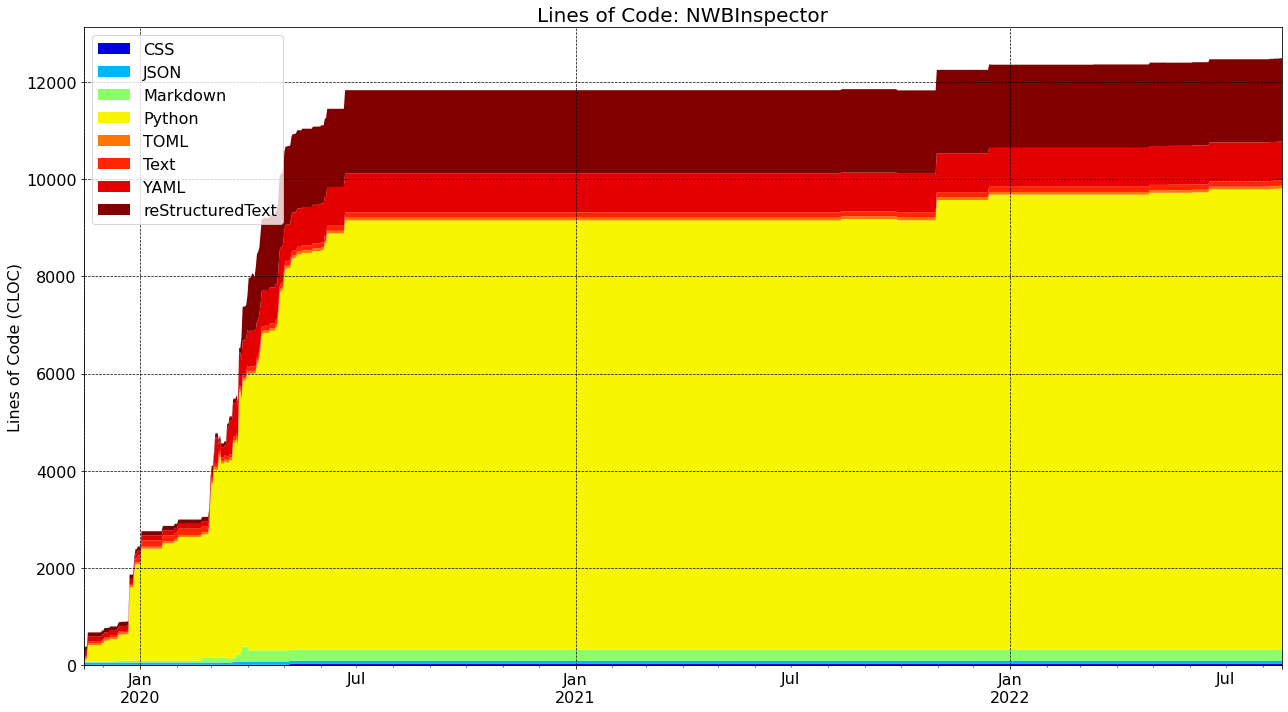

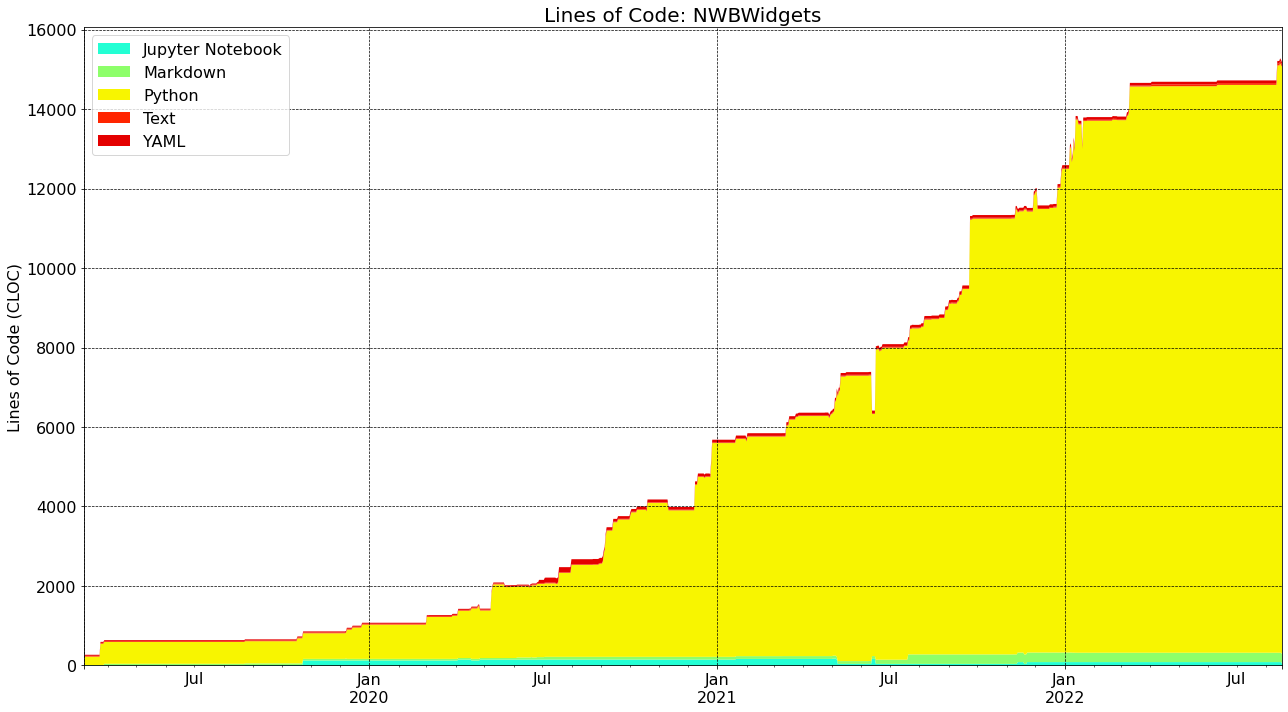

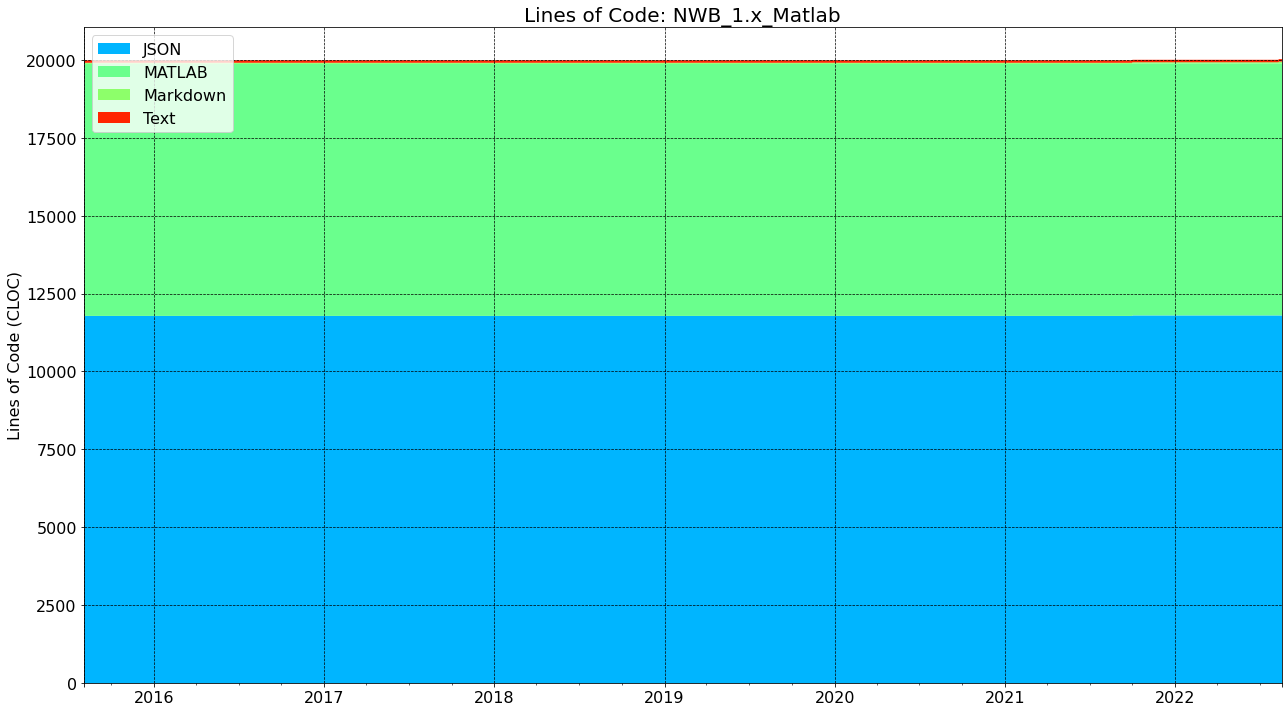

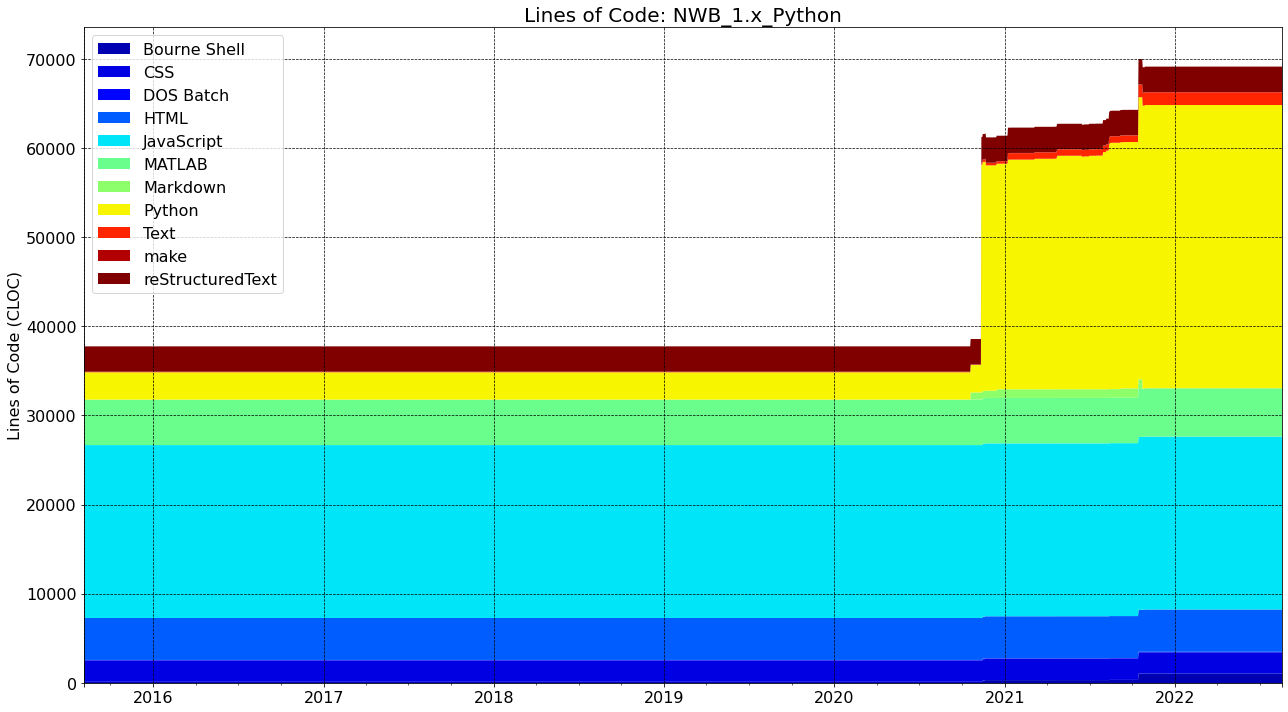

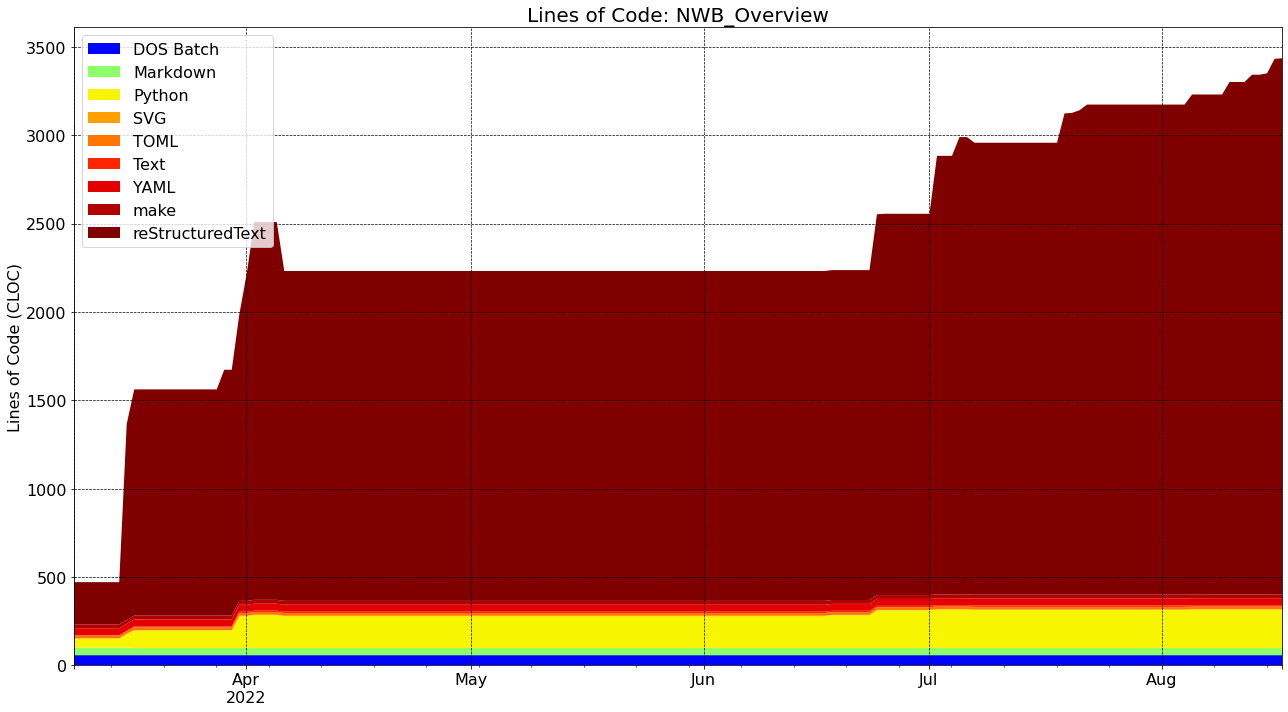

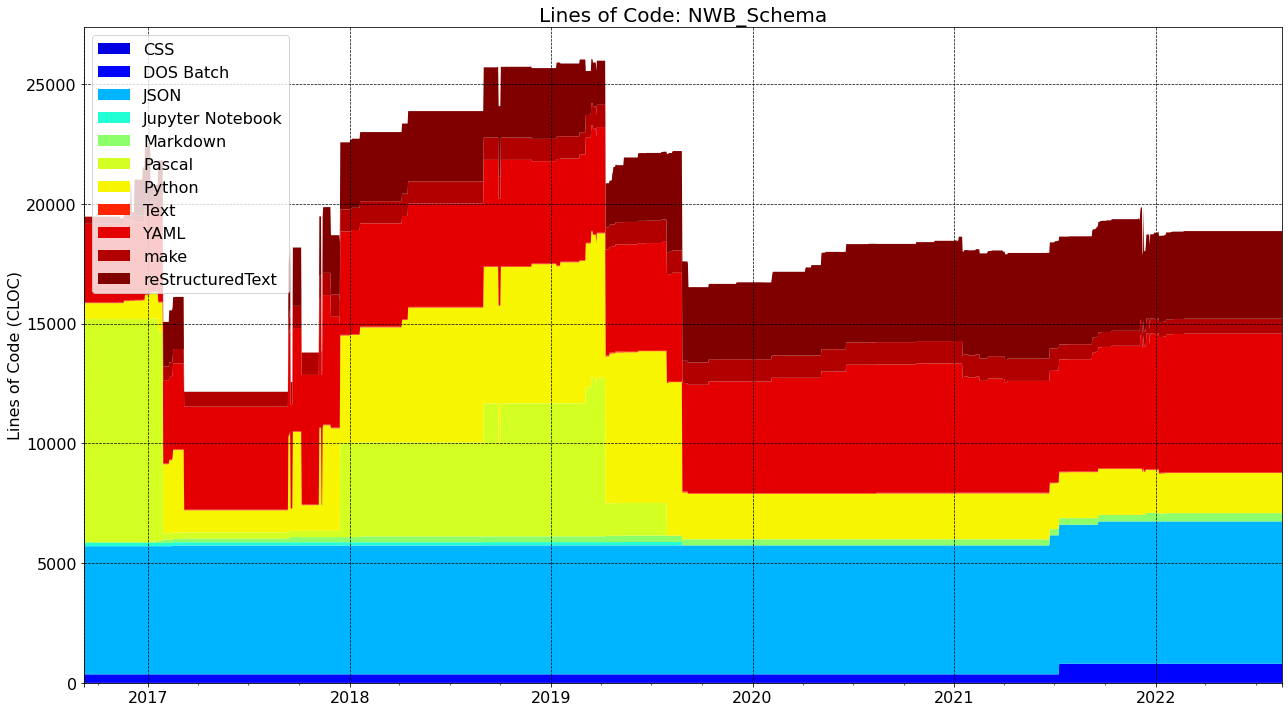

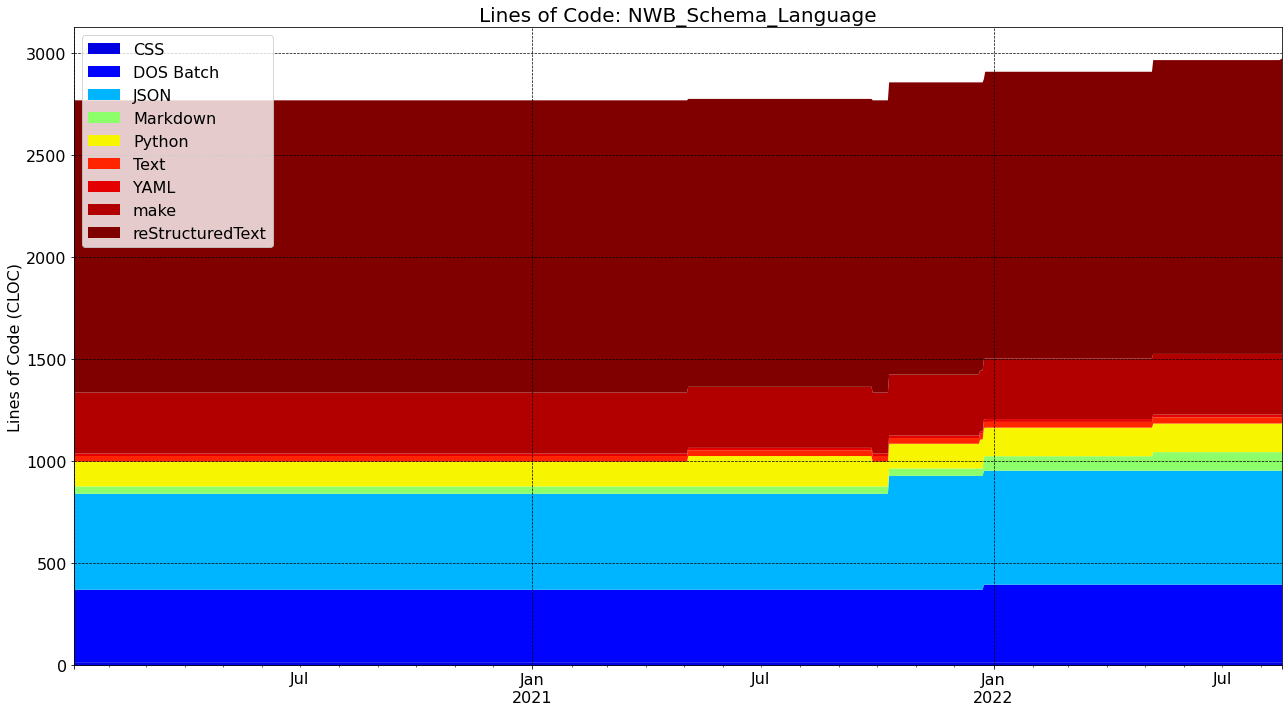

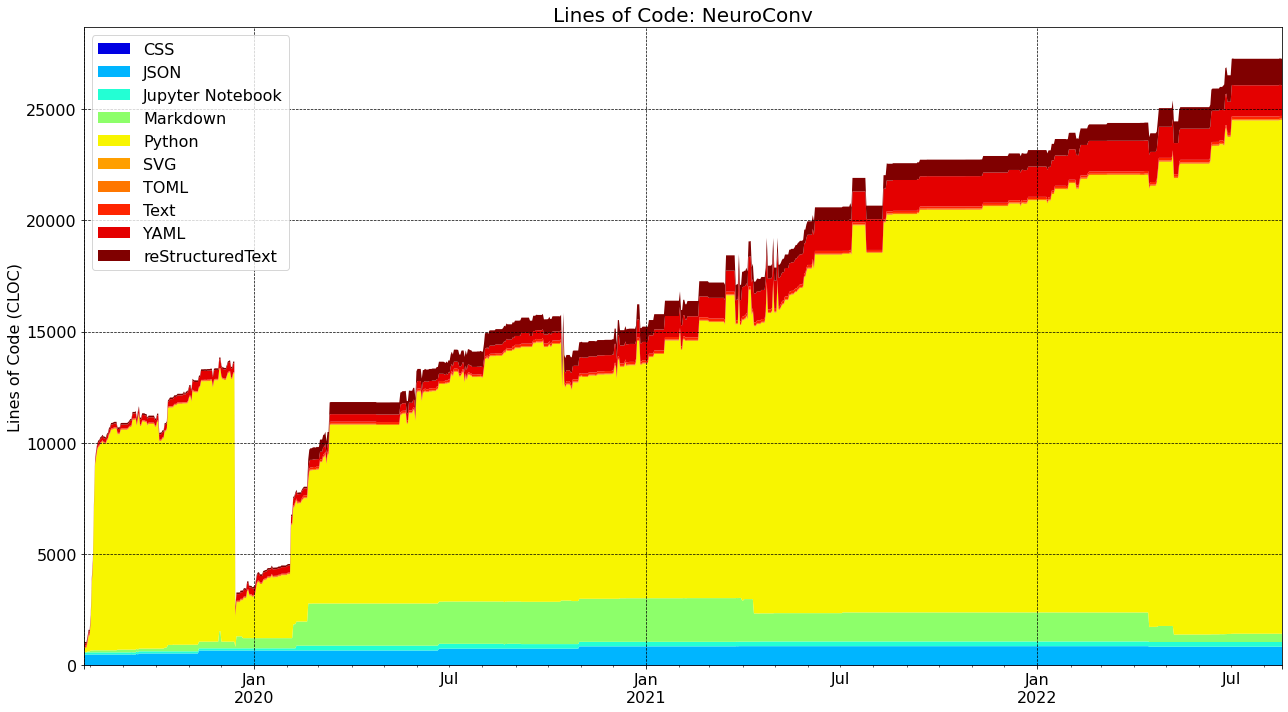

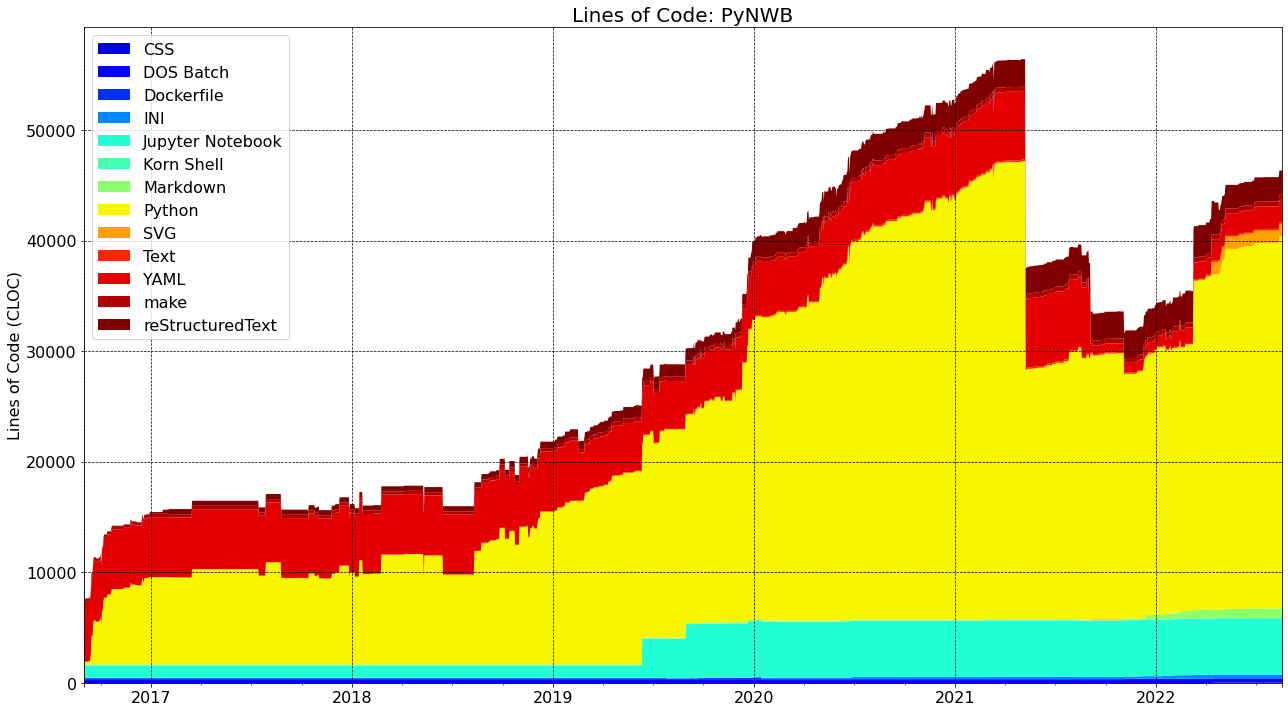

In [12]:
# Create unique colors per language so we can be consistent across plots
evenly_spaced_interval = np.linspace(0, 1, len(languages_used_all))
language_colors = {languages_used_all[i]:cm.jet(x) #tab20(x) 
                   for i, x in enumerate(evenly_spaced_interval)}
# Iterate through all repos and plot the per-language LOC stats for each repo
for k, v in per_repo_lang_stats.items():
    v.plot.area( 
        figsize=(18,10), 
        stacked=True, 
        linewidth=0, 
        fontsize=16,
        color = [language_colors[l] for l in v.columns]
    )
    plt.legend(loc=2, prop={'size': 16})
    plt.ylabel('Lines of Code (CLOC)', fontsize=16)
    plt.grid(color='black', linestyle='--', linewidth=0.7, axis='both')
    plt.title("Lines of Code: %s" % k, fontsize=20)
    plt.tight_layout()
    if save_figs:
        plt.savefig(os.path.join(plot_dir, '%s_language_loc.pdf' % k))
    plt.show()